# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

In [68]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)

# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)

#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Text"] =  (data["Text"].str.lower())
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Text'] = data['Text'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
##############Lets do the same for summary Text##################################
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
########################################################################################
# iii) Remove Special Characters except alpahbets and numbers
#The reason i dont want to remove number people might write got five eggs as 5 eggs or vice versa and dont want to lose 
#that information which could be useful
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Text"]=data["Text"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))
data["Summary_copy"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))

#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
#Ref:::::::::https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could','br','<br>','<','>']
notstopwords = ['not','no','nor']
stopwords.extend(newStopWords)
stopwords = [word for word in stopwords if word not in notstopwords]

#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Text"]= data['Text'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
data["Summary"]= data['Summary_copy'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])

#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Text"]=data["New_Text"].apply(' '.join)
data["Summary"]=data["Summary"].apply(' '.join)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Text"] = data["New_Text"].apply(english_stemmer.stem)
data["Summary"] = data["Summary"].apply(english_stemmer.stem)
data["New_Text"] = data["New_Text"].astype(str)
data["Summary"] = data["Summary"].astype(str)

#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Text_with_stop"]=data["Text"].astype(str)
data["Summary"]=data["Summary"].astype(str)
data["Text_with_stop"]=data["Text_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary"]=data["Summary"].str.lower().map(english_stemmer.stem)
data["Text_with_stop"]=data["Text_with_stop"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Text_with_stop"] = data["Text_with_stop"].astype(str)
data["Summary"] = data["Summary"].astype(str)
print(data["Score"].value_counts())
print ("Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced \
dataset we first copy negative dataset 6 times than we sample with same number of times as positive")
# Let include another feature which is the length of the text 
data_neg = data[data["Score"] == 0]
data_pos = data[data["Score"] == 1]
data = pd.concat([data_pos,data_neg])
#https://stackoverflow.com/questions/46429033/how-do-i-count-the-total-number-of-words-in-a-pandas-dataframe-cell-and-add-thos
data["Text_length"]= (data["New_Text"].str.count(' ') + 1)
data["Summary_length"]= (data["Summary"].str.count(' ') + 1)
data["Time_formatted"]= pd.to_datetime(data["Time"])
data.sort_values(by=['Time_formatted'], inplace=True)


Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
1    308679
0     57711
Name: Score, dtype: int64
Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced dataset we first copy negative dataset 6 times than we sample with same number of times as positive


In [69]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

Y = data['Score'].values
X_no_stop = data['New_Text'].values
X_summary = data ['Summary'].values

X_no_stop_train, X_no_stop_test, y_train, y_test = train_test_split(X_no_stop, Y, test_size=0.33, shuffle=False)
X_no_stop_train, X_no_stop_CV, y_train, y_CV = train_test_split(X_no_stop_train, y_train, test_size=0.33, shuffle=False)

X_summary_train,X_summary_test, y_summary_train, y_summary_test = train_test_split(X_summary, Y, test_size=0.33, shuffle=False)
X_summary_train,X_summary_CV, y_summary_train, y_summary_CV = train_test_split(X_summary_train,y_summary_train, test_size=0.33, shuffle=False)


## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [70]:
%time
from sklearn.feature_extraction.text import CountVectorizer
import math

bow_vect = CountVectorizer(ngram_range = (1,2),min_df = 7,max_features=9000)
bow_X_train_no_stop = bow_vect.fit_transform(X_no_stop_train)
bow_X_test_no_stop = bow_vect.transform(X_no_stop_test)
bow_X_CV_no_stop = bow_vect.transform(X_no_stop_CV)
##################################################
bow_X_summary_train = bow_vect.fit_transform(X_summary_train)
bow_X_summary_test = bow_vect.transform(X_summary_test)
bow_X_summary_CV = bow_vect.transform(X_summary_CV)
###############################################
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# creating list of hyperparameter for BOW SVM Regression

def tothepower(y):
    return (10**y)
hyperparam_SVM_BOW = list(map(tothepower, list(range(-4, 5))))
print (hyperparam_SVM_BOW)
hyperparam_SVM_BOW_log = [math.log(x) for x in hyperparam_SVM_BOW]
print (hyperparam_SVM_BOW_log)

Wall time: 0 ns
[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [71]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

bow_X_train_txt =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_train_no_stop)
bow_X_test_txt = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_test_no_stop)
bow_X_CV_txt = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_CV_no_stop)
########################################
bow_X_train_sum =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_train)
bow_X_test_sum = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_test)
bow_X_CV_sum = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_CV)
print (bow_X_train_txt.shape)

(164472, 9000)


In [72]:
from sklearn.linear_model import SGDClassifier
auc_cv_bow_txt_svm = []
auc_train_bow_txt_svm=[]

for hyperpara in tqdm(hyperparam_SVM_BOW):
    SVM_BOW_txt = SGDClassifier(loss='hinge',alpha=hyperpara,class_weight="balanced")
    SVM_BOW_txt.fit(bow_X_train_txt, y_train)
    pred_train_SVM_txt_bow=(SVM_BOW_txt.predict(bow_X_train_txt))
    pred_cv_SVM_txt_bow=(SVM_BOW_txt.predict(bow_X_CV_txt))
    auc_train_bow_txt_svm.append(roc_auc_score(y_train,pred_train_SVM_txt_bow))
    auc_cv_bow_txt_svm.append(roc_auc_score(y_CV,pred_cv_SVM_txt_bow))
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.07it/s]


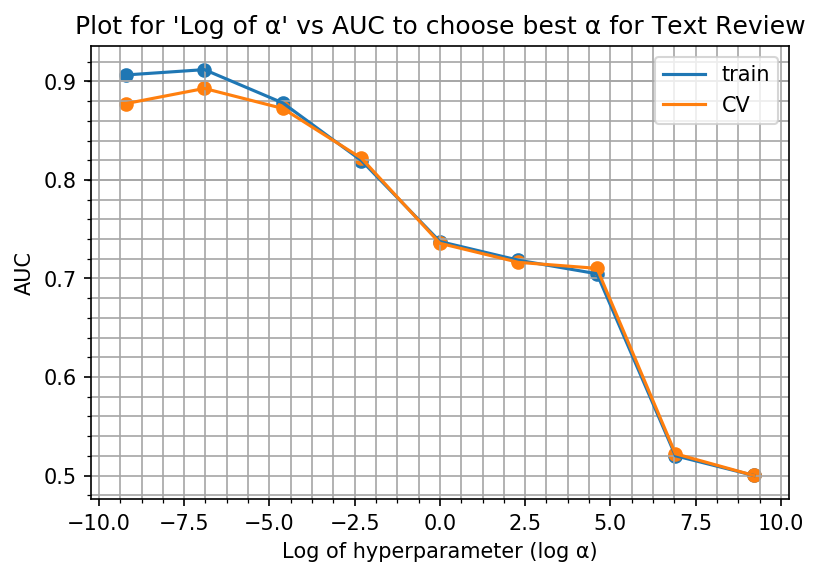

In [73]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(hyperparam_SVM_BOW_log, auc_train_bow_txt_svm)
plt.scatter(hyperparam_SVM_BOW_log, auc_train_bow_txt_svm)
plt.plot(hyperparam_SVM_BOW_log, auc_cv_bow_txt_svm)
plt.scatter(hyperparam_SVM_BOW_log, auc_cv_bow_txt_svm)
plt.xlabel('Log of hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'Log of α' vs AUC to choose best α for Text Review")
plt.legend(['train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [74]:
import numpy as np
lis_svm_bow = np.arange (.0001, .009, .0005)
print (lis_svm_bow)

[0.0001 0.0006 0.0011 0.0016 0.0021 0.0026 0.0031 0.0036 0.0041 0.0046
 0.0051 0.0056 0.0061 0.0066 0.0071 0.0076 0.0081 0.0086]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.05it/s]


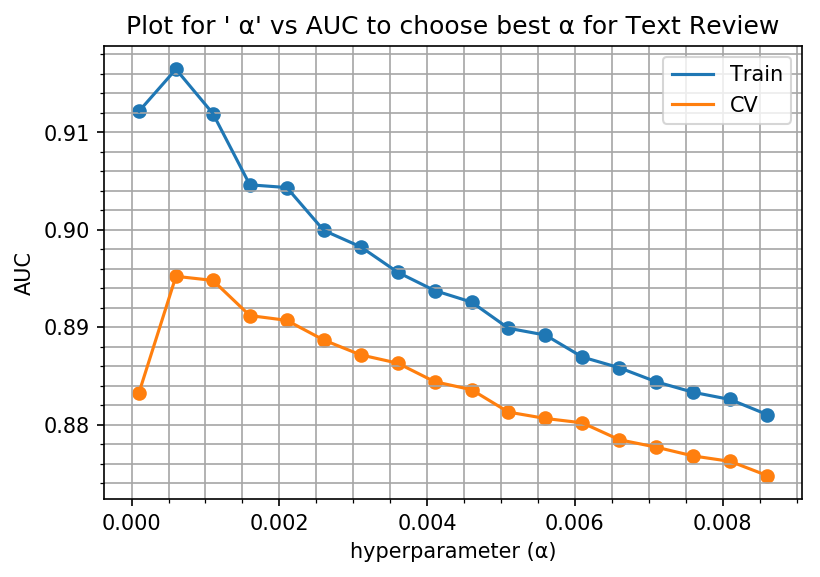

In [75]:
from sklearn.linear_model import SGDClassifier
auc_cv_bow_txt_svm = []
auc_train_bow_txt_svm=[]

for hyperpara in tqdm(lis_svm_bow):
    SVM_BOW_txt = SGDClassifier(loss='hinge',alpha=hyperpara,class_weight="balanced")
    SVM_BOW_txt.fit(bow_X_train_txt, y_train)
    pred_train_SVM_txt_bow=(SVM_BOW_txt.predict(bow_X_train_txt))
    pred_cv_SVM_txt_bow=(SVM_BOW_txt.predict(bow_X_CV_txt))
    auc_train_bow_txt_svm.append(roc_auc_score(y_train,pred_train_SVM_txt_bow))
    auc_cv_bow_txt_svm.append(roc_auc_score(y_CV,pred_cv_SVM_txt_bow))
    
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis_svm_bow, auc_train_bow_txt_svm)
plt.scatter(lis_svm_bow, auc_train_bow_txt_svm)
plt.plot(lis_svm_bow, auc_cv_bow_txt_svm)
plt.scatter(lis_svm_bow, auc_cv_bow_txt_svm)
plt.xlabel('hyperparameter (α)')
plt.ylabel('AUC')
plt.title("Plot for ' α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

The best α is 0.0006

In [76]:
SVM_BOW_txt = SGDClassifier(loss='hinge',alpha=0.0006,class_weight="balanced")
SVM_BOW_txt.fit(bow_X_train_txt, y_train)
best_alpha_pred_train_SVM_txt_bow=(SVM_BOW_txt.predict(bow_X_train_txt))
best_alpha_pred_test_SVM_txt_bow=(SVM_BOW_txt.predict(bow_X_test_txt))

In [77]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

SVM_BOW_txt_cal_cv = CalibratedClassifierCV(SGDClassifier(loss='hinge',alpha=0.0006,class_weight="balanced"),method='isotonic',cv=2)
SVM_BOW_txt_cal_cv.fit(bow_X_train_txt,y_train)
y_preds_test_bow_cal_cv = SVM_BOW_txt_cal_cv.predict_proba(bow_X_test_txt)
y_preds_train_bow_cal_cv = SVM_BOW_txt_cal_cv.predict_proba(bow_X_train_txt)
y_preds_test_bow_cal_cv_pos = y_preds_test_bow_cal_cv[:,1]
y_preds_train_bow_cal_cv_pos =  y_preds_train_bow_cal_cv[:,1]


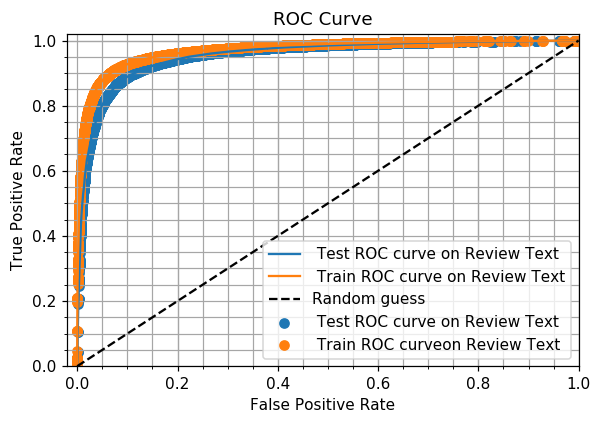

In [78]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_lin_SVM, tpr_test_bow_lin_SVM, thresholds = roc_curve(y_test, y_preds_test_bow_cal_cv_pos)
fpr_train_bow_lin_SVM, tpr_train_bow_lin_SVM, thresholds = roc_curve(y_train, y_preds_train_bow_cal_cv_pos)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_lin_SVM, tpr_test_bow_lin_SVM, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_bow_lin_SVM, tpr_test_bow_lin_SVM, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_bow_lin_SVM, tpr_train_bow_lin_SVM, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_bow_lin_SVM, tpr_train_bow_lin_SVM, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [79]:
l2_auc_test_BOW_lin_SVM  = (roc_auc_score(y_test,best_alpha_pred_test_SVM_txt_bow))
l2_auc_train_BOW_lin_SVM  = (roc_auc_score(y_train,best_alpha_pred_train_SVM_txt_bow))
print (l2_auc_test_BOW_lin_SVM)
print (l2_auc_train_BOW_lin_SVM)

0.8940625333047593
0.9166564413945094


In [80]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, best_alpha_pred_test_SVM_txt_bow))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, best_alpha_pred_train_SVM_txt_bow))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.66      0.89      0.75     21261
          1       0.97      0.90      0.94     99648

avg / total       0.92      0.90      0.90    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.64      0.91      0.76     22681
          1       0.99      0.92      0.95    141791

avg / total       0.94      0.92      0.92    164472



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


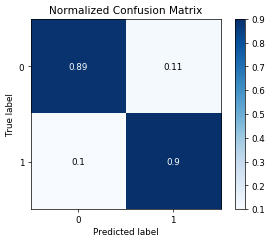

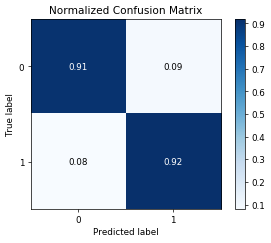

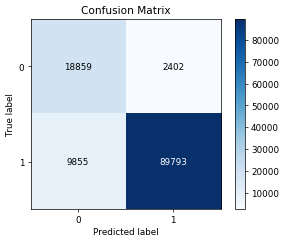

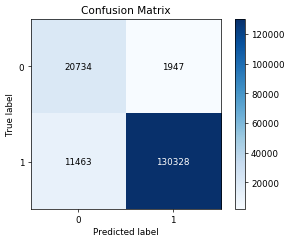

In [81]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_bow,normalize=True)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_bow,normalize=True)


from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_bow)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_bow)

##### Lets perform the same for L1

In [82]:
def tothepower(y):
    return (10**y)
hyperparam_SVM_BOW_l1 = list(map(tothepower, list(range(-5, 5))))
print (hyperparam_SVM_BOW_l1)
hyperparam_SVM_BOW_log_l1 = [math.log(x) for x in hyperparam_SVM_BOW_l1]
print (hyperparam_SVM_BOW_log_l1)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-11.512925464970229, -9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [83]:
from sklearn.linear_model import SGDClassifier
auc_cv_bow_txt_svm_l1 = []
auc_train_bow_txt_svm_l1=[]

for hyperpara in tqdm(hyperparam_SVM_BOW_l1):
    SVM_BOW_txt_l1 = SGDClassifier(loss='hinge',penalty='l1',alpha=hyperpara,class_weight="balanced")
    SVM_BOW_txt_l1.fit(bow_X_train_txt, y_train)
    pred_train_SVM_txt_bow_l1=(SVM_BOW_txt_l1.predict(bow_X_train_txt))
    pred_cv_SVM_txt_bow_l1=(SVM_BOW_txt_l1.predict(bow_X_CV_txt))
    auc_train_bow_txt_svm_l1.append(roc_auc_score(y_train,pred_train_SVM_txt_bow_l1))
    auc_cv_bow_txt_svm_l1.append(roc_auc_score(y_CV,pred_cv_SVM_txt_bow_l1))
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  2.12it/s]


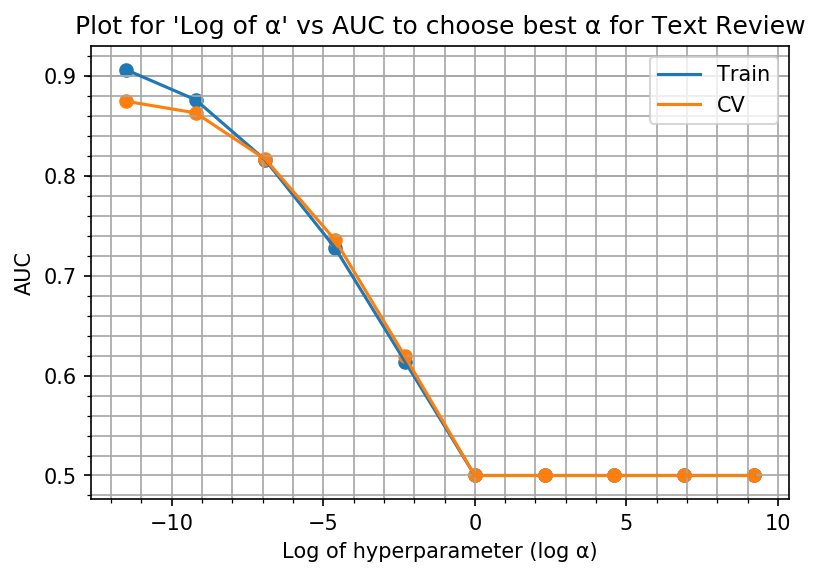

In [84]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(hyperparam_SVM_BOW_log_l1, auc_train_bow_txt_svm_l1)
plt.scatter(hyperparam_SVM_BOW_log_l1, auc_train_bow_txt_svm_l1)
plt.plot(hyperparam_SVM_BOW_log_l1, auc_cv_bow_txt_svm_l1)
plt.scatter(hyperparam_SVM_BOW_log_l1, auc_cv_bow_txt_svm_l1)
plt.xlabel('Log of hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'Log of α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

The best alpha is 0.00001 for L1 regulization

In [85]:
SVM_BOW_txt_l1 = SGDClassifier(loss='hinge',penalty='l1',alpha=0.00001,class_weight="balanced")
SVM_BOW_txt_l1.fit(bow_X_train_txt, y_train)
best_alpha_pred_train_SVM_txt_bow_l1=(SVM_BOW_txt_l1.predict(bow_X_train_txt))
best_alpha_pred_test_SVM_txt_bow_l1=(SVM_BOW_txt_l1.predict(bow_X_test_txt))

In [86]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

SVM_BOW_txt_cal_cv_l1 = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=0.00001,class_weight="balanced"),method='isotonic',cv=2)
SVM_BOW_txt_cal_cv_l1.fit(bow_X_train_txt,y_train)
y_preds_test_bow_cal_cv_l1 = SVM_BOW_txt_cal_cv_l1.predict_proba(bow_X_test_txt)
y_preds_train_bow_cal_cv_l1 = SVM_BOW_txt_cal_cv_l1.predict_proba(bow_X_train_txt)
y_preds_test_bow_cal_cv_l1_pos = y_preds_test_bow_cal_cv_l1[:,1]
y_preds_train_bow_cal_cv_l1_pos =  y_preds_train_bow_cal_cv_l1[:,1]

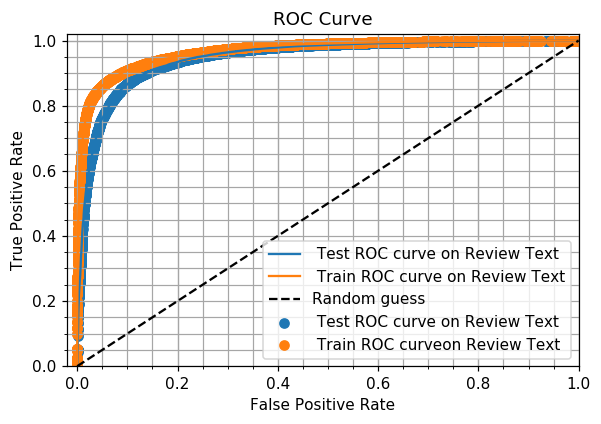

In [87]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_lin_SVM_l1, tpr_test_bow_lin_SVM_l1, thresholds = roc_curve(y_test, y_preds_test_bow_cal_cv_l1_pos)
fpr_train_bow_lin_SVM_l1, tpr_train_bow_lin_SVM_l1, thresholds = roc_curve(y_train, y_preds_train_bow_cal_cv_l1_pos)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_lin_SVM_l1, tpr_test_bow_lin_SVM_l1, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_bow_lin_SVM_l1, tpr_test_bow_lin_SVM_l1, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_bow_lin_SVM_l1, tpr_train_bow_lin_SVM_l1, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_bow_lin_SVM_l1, tpr_train_bow_lin_SVM_l1, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [88]:
l1_auc_test_BOW_lin_SVM  = (roc_auc_score(y_test,best_alpha_pred_test_SVM_txt_bow_l1))
l1_auc_train_BOW_lin_SVM  = (roc_auc_score(y_train,best_alpha_pred_train_SVM_txt_bow_l1))
print (l1_auc_test_BOW_lin_SVM)
print (l1_auc_train_BOW_lin_SVM)

0.8771473399262256
0.9051233311480595


In [89]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, best_alpha_pred_test_SVM_txt_bow_l1))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, best_alpha_pred_train_SVM_txt_bow_l1))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.62      0.87      0.72     21261
          1       0.97      0.89      0.93     99648

avg / total       0.91      0.88      0.89    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.61      0.90      0.73     22681
          1       0.98      0.91      0.94    141791

avg / total       0.93      0.91      0.91    164472



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


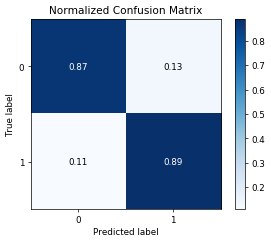

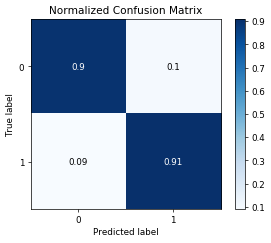

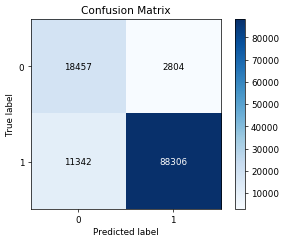

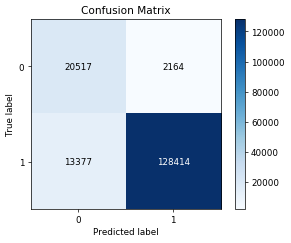

In [90]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_bow_l1,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_bow_l1,normalize=True)
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_bow_l1)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_bow_l1)


Top 10 positive features for L1 with BOW

In [91]:
coef_l1_bow =SVM_BOW_txt_l1.coef_
bow_features_name_l1_txt = bow_vect.get_feature_names()
bow_l1_wght_df = pd.DataFrame(coef_l1_bow, columns = bow_features_name_l1_txt)
bow_l1_wght_df_trans = bow_l1_wght_df.T
bow_l1_wght_df_trans.columns = ["Weight"]
print (bow_l1_wght_df_trans.sort_values('Weight',ascending=False).head(10))

                   Weight
agree          177.516778
kernel         171.501034
option         169.734039
great kit      164.142134
milk suppli    162.458463
bergin nut     147.990607
great formula  147.671871
mighty leaf    147.635044
best grain     139.446113
orange         136.296232


Top 10 negative features for L1 with BOW 

In [92]:
print (bow_l1_wght_df_trans.sort_values('Weight',ascending=False).tail(10))

                    Weight
great little   -187.750960
great light    -189.251206
tug jug        -192.695700
ultra          -198.042936
delightful tea -213.377697
healthy way    -217.626445
quest          -220.603795
mmmmmmmmm      -226.895584
monkey         -262.444889
wrong item     -264.198322


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,5))
tfidf_X_train = tf_idf_vect.fit_transform(X_no_stop_train)
tfidf_X_test = tf_idf_vect.transform(X_no_stop_test)
tfidf_X_CV = tf_idf_vect.transform(X_no_stop_CV)

tfidf_X_train =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_train)
tfidf_X_test = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_test)
tfidf_X_CV = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_CV)

def tothepower(y):
    return (10**y)
hyperparam_SVM = list(map(tothepower, list(range(-5, 5))))
print (hyperparam_SVM)
hyperparam_SVM_log = [math.log(x) for x in hyperparam_SVM]
print (hyperparam_SVM_log)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-11.512925464970229, -9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [94]:
from sklearn.linear_model import SGDClassifier
auc_cv_tfidf_txt_svm_l2 = []
auc_train_tfidf_txt_svm_l2=[]

for hyperpara in tqdm(hyperparam_SVM):
    SVM_tfidf_l2 = SGDClassifier(loss='hinge',penalty='l2',alpha=hyperpara,class_weight="balanced")
    SVM_tfidf_l2.fit(tfidf_X_train, y_train)
    pred_train_SVM_txt_tfidf_l2=(SVM_tfidf_l2.predict(tfidf_X_train))
    pred_cv_SVM_txt_tfidf_l2=(SVM_tfidf_l2.predict(tfidf_X_CV))
    auc_train_tfidf_txt_svm_l2.append(roc_auc_score(y_train,pred_train_SVM_txt_tfidf_l2))
    auc_cv_tfidf_txt_svm_l2.append(roc_auc_score(y_CV,pred_cv_SVM_txt_tfidf_l2))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


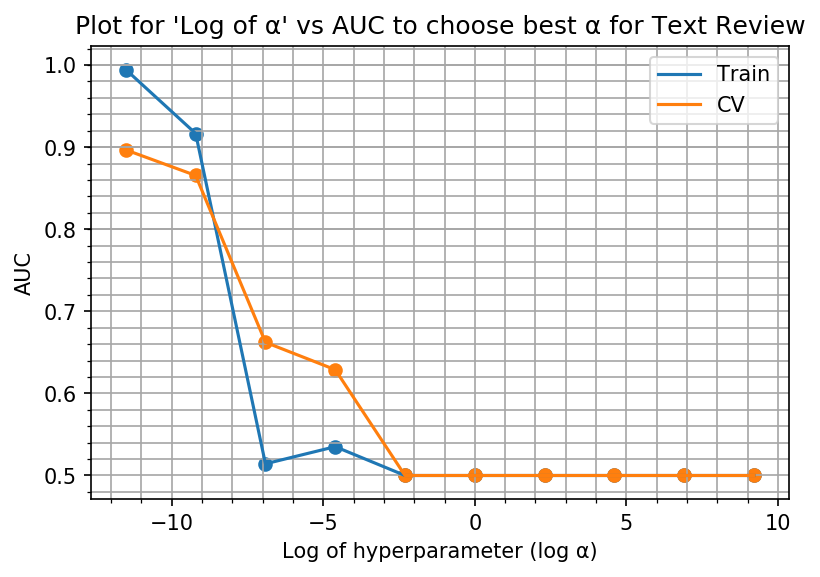

In [95]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(hyperparam_SVM_log, auc_train_tfidf_txt_svm_l2)
plt.scatter(hyperparam_SVM_log, auc_train_tfidf_txt_svm_l2)
plt.plot(hyperparam_SVM_log, auc_cv_tfidf_txt_svm_l2)
plt.scatter(hyperparam_SVM_log, auc_cv_tfidf_txt_svm_l2)
plt.xlabel('Log of hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'Log of α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

The Best alpha for L2 regulization for TFIDF is 0.00001

In [96]:
best_alpha_SVM_tfidf_l2 = SGDClassifier(loss='hinge',penalty='l2',alpha= 0.00001,class_weight="balanced")
best_alpha_SVM_tfidf_l2.fit(tfidf_X_train, y_train)
best_alpha_pred_train_SVM_txt_tfidf_l2=(best_alpha_SVM_tfidf_l2.predict(tfidf_X_train))
best_alpha_pred_test_SVM_txt_tfidf_l2=(best_alpha_SVM_tfidf_l2.predict(tfidf_X_test))

In [97]:
l2_auc_test_tfidf_lin_SVM  = (roc_auc_score(y_test,best_alpha_pred_test_SVM_txt_tfidf_l2))
l2_auc_train_tfidf_lin_SVM  = (roc_auc_score(y_train,best_alpha_pred_train_SVM_txt_tfidf_l2))
print (l2_auc_test_tfidf_lin_SVM)
print (l2_auc_train_tfidf_lin_SVM)

0.8986041413255965
0.9934366156505104


In [98]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

SVM_tfidf_cal_l2 = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=0.00001,class_weight="balanced"),method='isotonic',cv=2)
SVM_tfidf_cal_l2.fit(tfidf_X_train, y_train)
proba_pred_lin_SVM_tfidf_l2_train = SVM_tfidf_cal_l2.predict_proba(tfidf_X_train)
proba_pred_lin_SVM_tfidf_l2_test = SVM_tfidf_cal_l2.predict_proba(tfidf_X_test)
proba_pred_lin_SVM_tfidf_l2_train_pos = proba_pred_lin_SVM_tfidf_l2_train[:,1]
proba_pred_lin_SVM_tfidf_l2_test_pos =  proba_pred_lin_SVM_tfidf_l2_test[:,1]

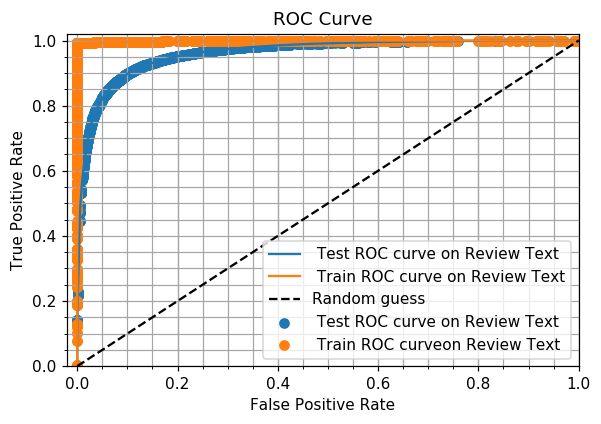

In [99]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidf_lin_SVM_l2, tpr_test_tfidf_lin_SVM_l2, thresholds = roc_curve(y_test, proba_pred_lin_SVM_tfidf_l2_test_pos)
fpr_train_tfidf_lin_SVM_l2, tpr_train_tfidf_lin_SVM_l2, thresholds = roc_curve(y_train, proba_pred_lin_SVM_tfidf_l2_train_pos)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidf_lin_SVM_l2, tpr_test_tfidf_lin_SVM_l2, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidf_lin_SVM_l2, tpr_test_tfidf_lin_SVM_l2, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidf_lin_SVM_l2, tpr_train_tfidf_lin_SVM_l2, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidf_lin_SVM_l2, tpr_train_tfidf_lin_SVM_l2, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [100]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, best_alpha_pred_test_SVM_txt_tfidf_l2))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, best_alpha_pred_train_SVM_txt_tfidf_l2))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.71      0.87      0.78     21261
          1       0.97      0.92      0.95     99648

avg / total       0.93      0.92      0.92    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.93      1.00      0.96     22681
          1       1.00      0.99      0.99    141791

avg / total       0.99      0.99      0.99    164472



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


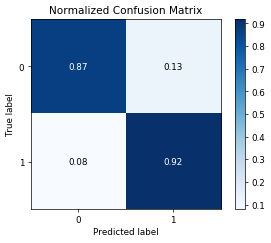

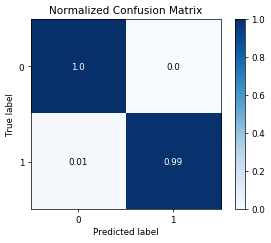

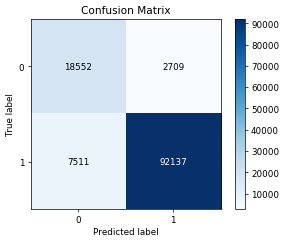

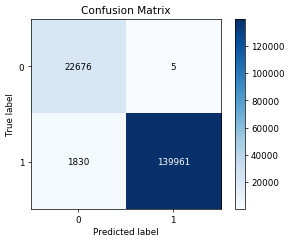

In [101]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_tfidf_l2,normalize=True)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_tfidf_l2,normalize=True)
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_tfidf_l2)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_tfidf_l2)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")

#### Lets perform for L1

In [102]:
from sklearn.linear_model import SGDClassifier
auc_cv_tfidf_txt_svm_l1 = []
auc_train_tfidf_txt_svm_l1=[]

for hyperpara in tqdm(hyperparam_SVM):
    SVM_tfidf_l1 = SGDClassifier(loss='hinge',penalty='l1',alpha=hyperpara,class_weight="balanced")
    SVM_tfidf_l1.fit(tfidf_X_train, y_train)
    pred_train_SVM_txt_tfidf_l1=(SVM_tfidf_l1.predict(tfidf_X_train))
    pred_cv_SVM_txt_tfidf_l1=(SVM_tfidf_l1.predict(tfidf_X_CV))
    auc_train_tfidf_txt_svm_l1.append(roc_auc_score(y_train,pred_train_SVM_txt_tfidf_l1))
    auc_cv_tfidf_txt_svm_l1.append(roc_auc_score(y_CV,pred_cv_SVM_txt_tfidf_l1))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.77s/it]


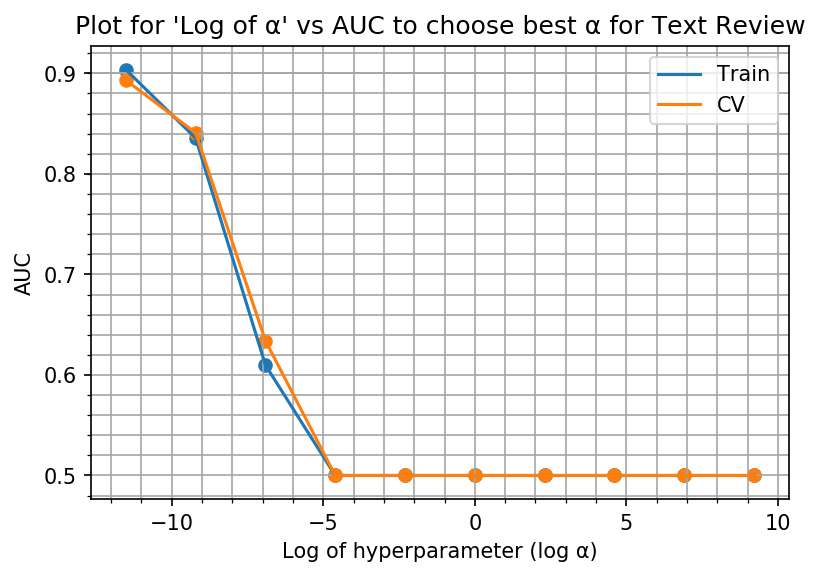

In [103]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(hyperparam_SVM_log, auc_train_tfidf_txt_svm_l1)
plt.scatter(hyperparam_SVM_log, auc_train_tfidf_txt_svm_l1)
plt.plot(hyperparam_SVM_log, auc_cv_tfidf_txt_svm_l1)
plt.scatter(hyperparam_SVM_log, auc_cv_tfidf_txt_svm_l1)
plt.xlabel('Log of hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'Log of α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

The best alpha is 0.00001 for L1

In [104]:
best_alpha_SVM_tfidf_l1 = SGDClassifier(loss='hinge',penalty='l1',alpha= 0.00001,class_weight="balanced")
best_alpha_SVM_tfidf_l1.fit(tfidf_X_train, y_train)
best_alpha_pred_train_SVM_txt_tfidf_l1=(best_alpha_SVM_tfidf_l1.predict(tfidf_X_train))
best_alpha_pred_test_SVM_txt_tfidf_l1=(best_alpha_SVM_tfidf_l1.predict(tfidf_X_test))

In [105]:
l1_auc_test_tfidf_lin_SVM  = (roc_auc_score(y_test,best_alpha_pred_test_SVM_txt_tfidf_l1))
l1_auc_train_tfidf_lin_SVM  = (roc_auc_score(y_train,best_alpha_pred_train_SVM_txt_tfidf_l1))
print (l1_auc_test_tfidf_lin_SVM)
print (l1_auc_train_tfidf_lin_SVM)

0.894896547771395
0.9050328796658099


In [106]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

SVM_tfidf_cal_l1 = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=0.00001,class_weight="balanced"),method='isotonic',cv=2)
SVM_tfidf_cal_l1.fit(tfidf_X_train, y_train)
proba_pred_lin_SVM_tfidf_l1_train = SVM_tfidf_cal_l1.predict_proba(tfidf_X_train)
proba_pred_lin_SVM_tfidf_l1_test = SVM_tfidf_cal_l1.predict_proba(tfidf_X_test)
proba_pred_lin_SVM_tfidf_l1_train_pos = proba_pred_lin_SVM_tfidf_l1_train[:,1]
proba_pred_lin_SVM_tfidf_l1_test_pos =  proba_pred_lin_SVM_tfidf_l1_test[:,1]

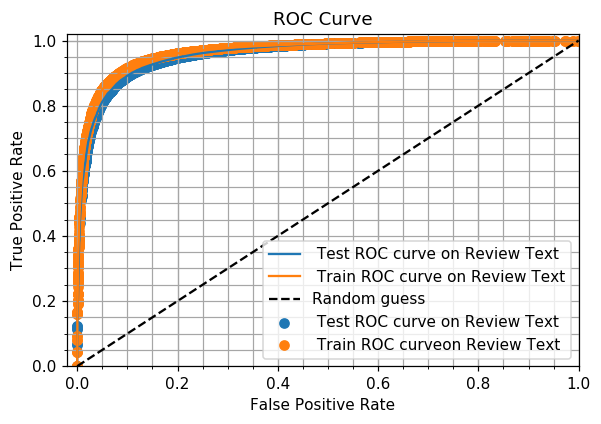

In [107]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidf_lin_SVM_l1, tpr_test_tfidf_lin_SVM_l1, thresholds = roc_curve(y_test, proba_pred_lin_SVM_tfidf_l1_test_pos)
fpr_train_tfidf_lin_SVM_l1, tpr_train_tfidf_lin_SVM_l1, thresholds = roc_curve(y_train, proba_pred_lin_SVM_tfidf_l1_train_pos)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidf_lin_SVM_l1, tpr_test_tfidf_lin_SVM_l1, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidf_lin_SVM_l1, tpr_test_tfidf_lin_SVM_l1, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidf_lin_SVM_l1, tpr_train_tfidf_lin_SVM_l1, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidf_lin_SVM_l1, tpr_train_tfidf_lin_SVM_l1, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [108]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, best_alpha_pred_test_SVM_txt_tfidf_l1))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, best_alpha_pred_train_SVM_txt_tfidf_l1))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.65      0.89      0.75     21261
          1       0.98      0.90      0.93     99648

avg / total       0.92      0.90      0.90    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.60      0.91      0.72     22681
          1       0.98      0.90      0.94    141791

avg / total       0.93      0.90      0.91    164472



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


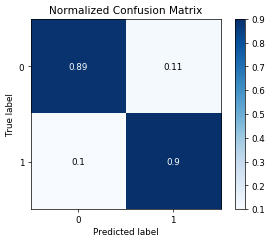

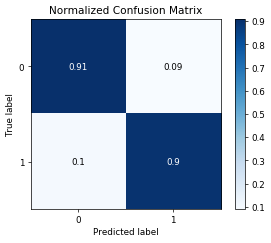

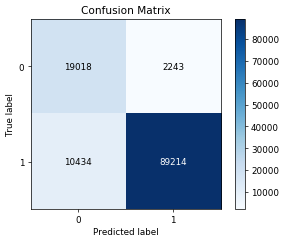

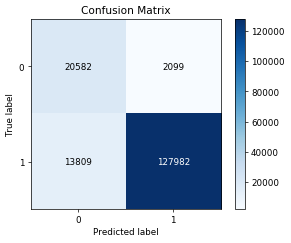

In [109]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_tfidf_l1,normalize=True)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_tfidf_l1,normalize=True)
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_tfidf_l1)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_tfidf_l1)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")

The TOP 10 positive features for L1 with TFIDF

In [110]:
coef_l1_tfidf =best_alpha_SVM_tfidf_l1.coef_
tfidf_features_name_l1_txt = tf_idf_vect.get_feature_names()
tfidf_l1_wght_df = pd.DataFrame(coef_l1_tfidf, columns = tfidf_features_name_l1_txt)
tfidf_l1_wght_df_trans = tfidf_l1_wght_df.T
tfidf_l1_wght_df_trans.columns = ["Weight"]
print (tfidf_l1_wght_df_trans.sort_values('Weight',ascending=False).head(10))

              Weight
great      33.338330
delicious  29.651082
best       28.771500
perfect    27.768881
excellent  24.941459
good       22.971363
wonderful  21.986602
loves      21.703614
pleased    18.703371
lov        18.636398


The TOP 10 neagtive features for L1 with TFIDF

In [111]:
print (tfidf_l1_wght_df_trans.sort_values('Weight',ascending=False).tail(10))

                  Weight
not recommend -18.158029
not good      -18.879495
awful         -19.761189
horrible      -19.989159
unfortunately -20.826528
terrible      -21.493749
disappointing -21.992064
not worth     -23.640490
disappointed  -24.445913
worst         -26.409802


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [113]:
lst_train=[]
lst_test=[]
lst_of_lst_train = []
lst_of_lst_test = []
lst_of_lst_CV =[]
lst_CV = []

for sentance in tqdm(X_no_stop_train):
    lst_train.append(sentance.strip())
for sentance in tqdm(lst_train):
    lst_of_lst_train.append(sentance.split())

for sent in tqdm(X_no_stop_test):
    lst_test.append(sent.strip())
for sent in tqdm(lst_test):
    lst_of_lst_test.append(sent.split())
    
for sent_CV in tqdm(X_no_stop_CV):
    lst_CV.append(sent_CV.strip())
for sent_CV in tqdm(lst_CV):
    lst_of_lst_CV.append(sent_CV.split())
    
w2v_model_self_taught_train=Word2Vec(lst_of_lst_train,min_count=1,size=50, workers=4)
w2v_words_train = list(w2v_model_self_taught_train.wv.vocab)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81009/81009 [00:01<00:00, 52166.74it/s]


In [114]:
sent_vectors_train_l1 = []
for sent1 in tqdm(lst_of_lst_train): # for each review/sentence
    sent_vec1 = np.zeros(50)
    cnt_words1 = 0
    for word1 in sent1:
        if word1 in w2v_words_train:
            vec1 = w2v_model_self_taught_train.wv[word1]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    sent_vectors_train_l1.append(sent_vec1) 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164472/164472 [21:21<00:00, 128.38it/s]


In [115]:
sent_vectors_test_l1 = []
for sent2 in tqdm(lst_of_lst_test): # for each review/sentence
    sent_vec2 = np.zeros(50)
    cnt_words2 = 0
    for word2 in sent2:
        if word2 in w2v_words_train:
            vec2 = w2v_model_self_taught_train.wv[word2]
            sent_vec2 += vec2
            cnt_words2 += 1
    if cnt_words2 != 0:
        sent_vec2 /= cnt_words2
    sent_vectors_test_l1.append(sent_vec2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120909/120909 [22:00<00:00, 91.53it/s]


In [116]:
sent_vectors_CV_l1 = []
for sent3 in tqdm(lst_of_lst_CV): # for each review/sentence
    sent_vec3 = np.zeros(50)
    cnt_words3 = 0
    for word3 in sent3:
        if word3 in w2v_words_train:
            vec3 = w2v_model_self_taught_train.wv[word3]
            sent_vec3 += vec3
            cnt_words3 += 1
    if cnt_words3 != 0:
        sent_vec3 /= cnt_words3
    sent_vectors_CV_l1.append(sent_vec3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81009/81009 [15:05<00:00, 89.45it/s]


In [117]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sent_vectors_train_l1_std =StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_train_l1)
sent_vectors_test_l1_std = StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_test_l1)
sent_vectors_CV_l1_std = StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_CV_l1)

In [118]:
def tothepower(y):
    return (10**y)
hyperpara_avg_w2V = list(map(tothepower, list(range(-5, 5))))
print (hyperpara_avg_w2V)
hyperpara_avg_w2V_log = [math.log(x) for x in hyperpara_avg_w2V]
print (hyperpara_avg_w2V_log)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-11.512925464970229, -9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [119]:
from sklearn.linear_model import SGDClassifier
auc_cv_avg_w2v_txt_svm = []
auc_train_avg_w2v_txt_svm=[]

for hyperpara in tqdm(hyperpara_avg_w2V):
    SVM_avg_w2v_txt = SGDClassifier(loss='hinge',alpha=hyperpara,class_weight="balanced")
    SVM_avg_w2v_txt.fit(sent_vectors_train_l1_std, y_train)
    pred_train_SVM_txt_avg_w2v=(SVM_avg_w2v_txt.predict(sent_vectors_train_l1_std))
    pred_cv_SVM_txt_avg_w2v=(SVM_avg_w2v_txt.predict(sent_vectors_CV_l1_std))
    auc_train_avg_w2v_txt_svm.append(roc_auc_score(y_train,pred_train_SVM_txt_avg_w2v))
    auc_cv_avg_w2v_txt_svm.append(roc_auc_score(y_CV,pred_cv_SVM_txt_avg_w2v))
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.93it/s]


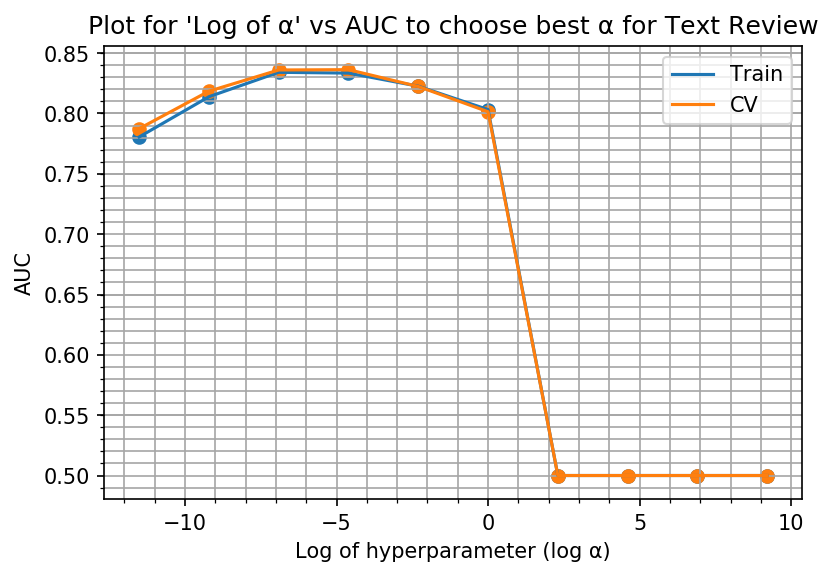

In [120]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(hyperpara_avg_w2V_log, auc_train_avg_w2v_txt_svm)
plt.scatter(hyperpara_avg_w2V_log, auc_train_avg_w2v_txt_svm)
plt.plot(hyperpara_avg_w2V_log, auc_cv_avg_w2v_txt_svm)
plt.scatter(hyperpara_avg_w2V_log, auc_cv_avg_w2v_txt_svm)
plt.xlabel('Log of hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'Log of α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [140]:
import numpy as np
lis_svm_avg_w2v = np.arange (.0001, .01, .0005)
print (lis_svm_avg_w2v)

[0.0001 0.0006 0.0011 0.0016 0.0021 0.0026 0.0031 0.0036 0.0041 0.0046
 0.0051 0.0056 0.0061 0.0066 0.0071 0.0076 0.0081 0.0086 0.0091 0.0096]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


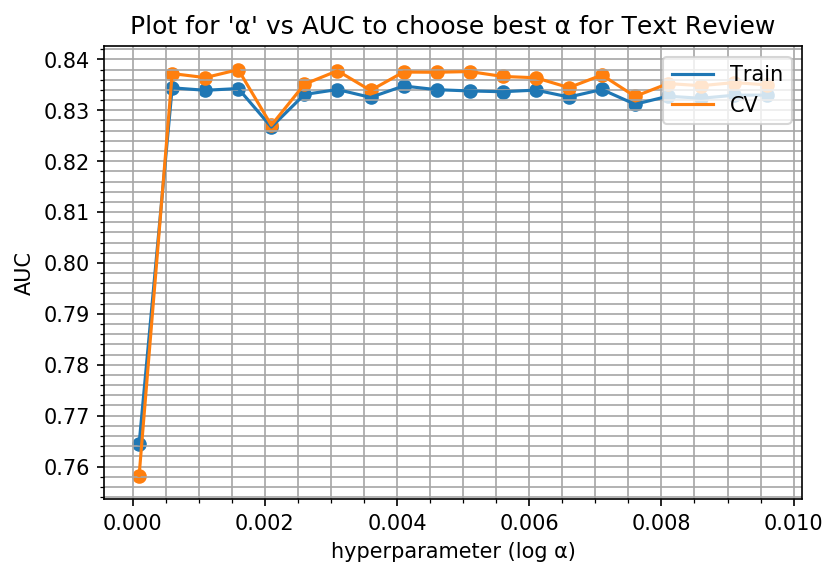

In [141]:
auc_train_avg_w2v_txt_svm = []
auc_cv_avg_w2v_txt_svm = []
for hyperpara in tqdm(lis_svm_avg_w2v):
    SVM_avg_w2v_txt = SGDClassifier(loss='hinge',alpha=hyperpara,class_weight="balanced")
    SVM_avg_w2v_txt.fit(sent_vectors_train_l1_std, y_train)
    pred_train_SVM_txt_avg_w2v=(SVM_avg_w2v_txt.predict(sent_vectors_train_l1_std))
    pred_cv_SVM_txt_avg_w2v=(SVM_avg_w2v_txt.predict(sent_vectors_CV_l1_std))
    auc_train_avg_w2v_txt_svm.append(roc_auc_score(y_train,pred_train_SVM_txt_avg_w2v))
    auc_cv_avg_w2v_txt_svm.append(roc_auc_score(y_CV,pred_cv_SVM_txt_avg_w2v))



default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis_svm_avg_w2v, auc_train_avg_w2v_txt_svm)
plt.scatter(lis_svm_avg_w2v, auc_train_avg_w2v_txt_svm)
plt.plot(lis_svm_avg_w2v, auc_cv_avg_w2v_txt_svm)
plt.scatter(lis_svm_avg_w2v, auc_cv_avg_w2v_txt_svm)
plt.xlabel('hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

the best parameter is 0.0016

In [142]:
best_alpha_SVM_avg_w2v_txt = SGDClassifier(loss='hinge',alpha=0.0016,class_weight="balanced")
best_alpha_SVM_avg_w2v_txt.fit(sent_vectors_train_l1_std, y_train)
best_alpha_pred_train_SVM_txt_avg_w2v=(best_alpha_SVM_avg_w2v_txt.predict(sent_vectors_train_l1_std))
best_alpha_pred_test_SVM_txt_avg_w2v=(best_alpha_SVM_avg_w2v_txt.predict(sent_vectors_test_l1_std))

In [143]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

SVM_avgw2v_cal_l2 = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=0.0016,class_weight="balanced"),method='isotonic',cv=2)
SVM_avgw2v_cal_l2.fit(sent_vectors_train_l1_std, y_train)
proba_pred_lin_SVM_avgw2v_l2_train = SVM_avgw2v_cal_l2.predict_proba(sent_vectors_train_l1_std)
proba_pred_lin_SVM_avgw2v_l2_test = SVM_avgw2v_cal_l2.predict_proba(sent_vectors_test_l1_std)
proba_pred_lin_SVM_avgw2v_l2_train_pos = proba_pred_lin_SVM_avgw2v_l2_train[:,1]
proba_pred_lin_SVM_avgw2v_l2_test_pos =  proba_pred_lin_SVM_avgw2v_l2_test[:,1]

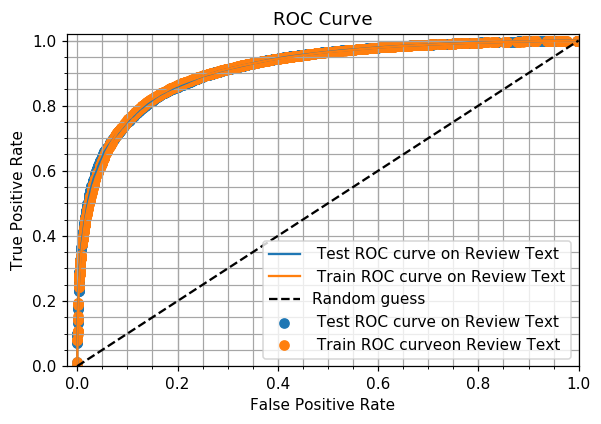

In [144]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avgwv_lin_SVM_l2, tpr_test_avgw2v_lin_SVM_l2, thresholds = roc_curve(y_test, proba_pred_lin_SVM_avgw2v_l2_test_pos)
fpr_train_avgw2v_lin_SVM_l2, tpr_train_avgw2v_lin_SVM_l2, thresholds = roc_curve(y_train, proba_pred_lin_SVM_avgw2v_l2_train_pos)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avgwv_lin_SVM_l2, tpr_test_avgw2v_lin_SVM_l2, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avgwv_lin_SVM_l2, tpr_test_avgw2v_lin_SVM_l2, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avgw2v_lin_SVM_l2, tpr_train_avgw2v_lin_SVM_l2, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avgw2v_lin_SVM_l2, tpr_train_avgw2v_lin_SVM_l2, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [145]:
l2_auc_test_avgw2v_lin_SVM  = (roc_auc_score(y_test,best_alpha_pred_test_SVM_txt_avg_w2v))
l2_auc_train_avgw2v_lin_SVM  = (roc_auc_score(y_train,best_alpha_pred_train_SVM_txt_avg_w2v))
print (l2_auc_test_avgw2v_lin_SVM)
print (l2_auc_train_avgw2v_lin_SVM)

0.8132900761151952
0.8204135395306458


In [146]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, best_alpha_pred_test_SVM_txt_avg_w2v))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, best_alpha_pred_train_SVM_txt_avg_w2v))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.40      0.93      0.56     21261
          1       0.98      0.70      0.82     99648

avg / total       0.88      0.74      0.77    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.35      0.91      0.50     22681
          1       0.98      0.73      0.84    141791

avg / total       0.89      0.75      0.79    164472



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


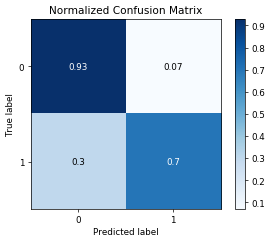

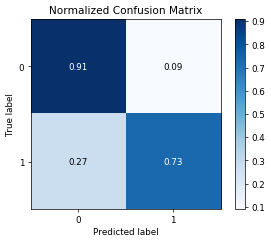

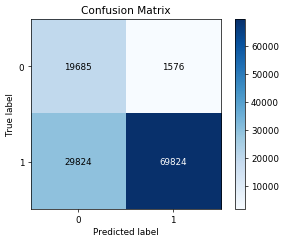

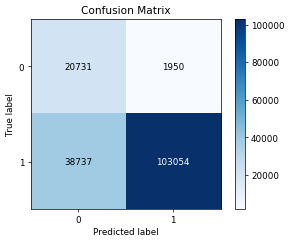

In [147]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_avg_w2v,normalize=True)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_avg_w2v,normalize=True)
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_avg_w2v)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_avg_w2v)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")

In [129]:
from sklearn.linear_model import SGDClassifier
auc_cv_avg_w2v_txt_svm_l1 = []
auc_train_avg_w2v_txt_svm_l1=[]

for hyperpara in tqdm(hyperpara_avg_w2V):
    SVM_avg_w2v_txt_l1 = SGDClassifier(loss='hinge',penalty='l1',alpha=hyperpara,class_weight="balanced")
    SVM_avg_w2v_txt_l1.fit(sent_vectors_train_l1_std, y_train)
    l1_pred_train_SVM_txt_avg_w2v=(SVM_avg_w2v_txt_l1.predict(sent_vectors_train_l1_std))
    l1_pred_cv_SVM_txt_avg_w2v=(SVM_avg_w2v_txt_l1.predict(sent_vectors_CV_l1_std))
    auc_train_avg_w2v_txt_svm_l1.append(roc_auc_score(y_train,l1_pred_train_SVM_txt_avg_w2v))
    auc_cv_avg_w2v_txt_svm_l1.append(roc_auc_score(y_CV,l1_pred_cv_SVM_txt_avg_w2v))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.56it/s]


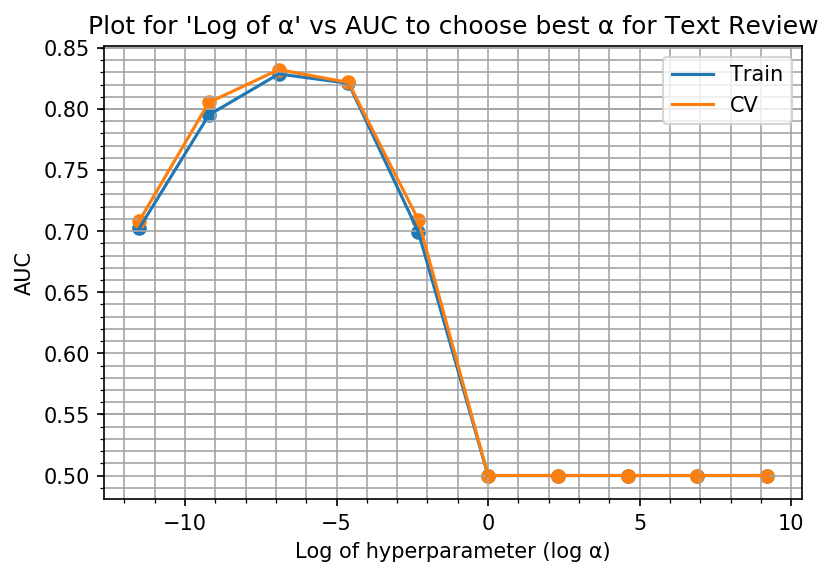

In [130]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(hyperpara_avg_w2V_log, auc_train_avg_w2v_txt_svm_l1)
plt.scatter(hyperpara_avg_w2V_log, auc_train_avg_w2v_txt_svm_l1)
plt.plot(hyperpara_avg_w2V_log, auc_cv_avg_w2v_txt_svm_l1)
plt.scatter(hyperpara_avg_w2V_log, auc_cv_avg_w2v_txt_svm_l1)
plt.xlabel('Log of hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'Log of α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [131]:
import numpy as np
lis_svm_avg_w2v_l1 = np.arange (.0001, .01, .0005)
print (lis_svm_avg_w2v_l1)

[0.0001 0.0006 0.0011 0.0016 0.0021 0.0026 0.0031 0.0036 0.0041 0.0046
 0.0051 0.0056 0.0061 0.0066 0.0071 0.0076 0.0081 0.0086 0.0091 0.0096]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


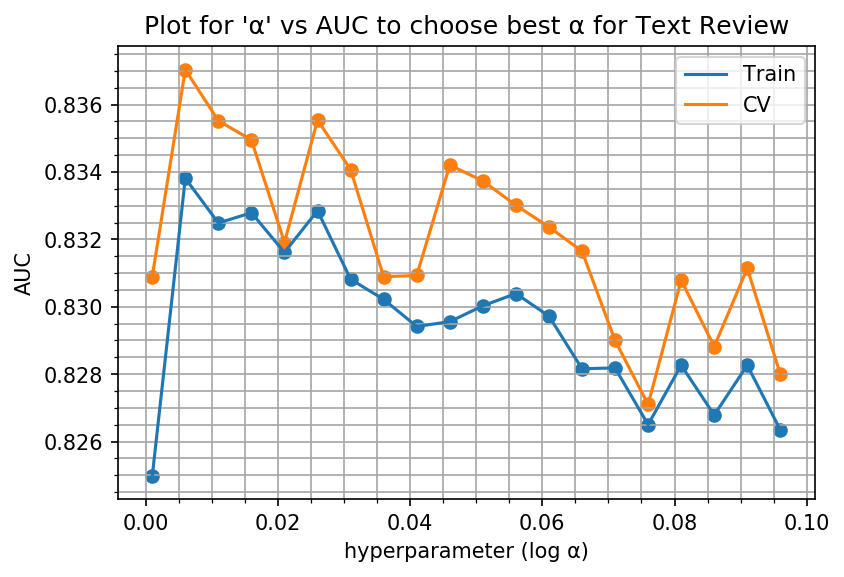

In [132]:
auc_train_avg_w2v_txt_svm_l1 = []
auc_cv_avg_w2v_txt_svm_l1 = []
for hyperpara in tqdm(lis_svm_avg_w2v_l1):
    SVM_avg_w2v_txt_l1 = SGDClassifier(loss='hinge',penalty ='l1',alpha=hyperpara,class_weight="balanced")
    SVM_avg_w2v_txt_l1.fit(sent_vectors_train_l1_std, y_train)
    pred_train_SVM_txt_avg_w2v_l1=(SVM_avg_w2v_txt_l1.predict(sent_vectors_train_l1_std))
    pred_cv_SVM_txt_avg_w2v_l1=(SVM_avg_w2v_txt_l1.predict(sent_vectors_CV_l1_std))
    auc_train_avg_w2v_txt_svm_l1.append(roc_auc_score(y_train,pred_train_SVM_txt_avg_w2v_l1))
    auc_cv_avg_w2v_txt_svm_l1.append(roc_auc_score(y_CV,pred_cv_SVM_txt_avg_w2v_l1))



default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis_svm_avg_w2v, auc_train_avg_w2v_txt_svm_l1)
plt.scatter(lis_svm_avg_w2v, auc_train_avg_w2v_txt_svm_l1)
plt.plot(lis_svm_avg_w2v, auc_cv_avg_w2v_txt_svm_l1)
plt.scatter(lis_svm_avg_w2v, auc_cv_avg_w2v_txt_svm_l1)
plt.xlabel('hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

The best hyperparamter is 0.0006

In [133]:
SVM_avg_w2v_txt_l1 = SGDClassifier(loss='hinge',penalty ='l1',alpha= 0.0006,class_weight="balanced")
SVM_avg_w2v_txt_l1.fit(sent_vectors_train_l1_std, y_train)
best_aplha_pred_train_SVM_txt_avg_w2v_l1=(SVM_avg_w2v_txt_l1.predict(sent_vectors_train_l1_std))
best_alpha_pred_test_SVM_txt_avg_w2v_l1=(SVM_avg_w2v_txt_l1.predict(sent_vectors_test_l1_std))

In [134]:
l1_auc_test_avgw2v_lin_SVM  = (roc_auc_score(y_test,best_alpha_pred_test_SVM_txt_avg_w2v_l1))
l1_auc_train_avgw2v_lin_SVM  = (roc_auc_score(y_train,best_aplha_pred_train_SVM_txt_avg_w2v_l1))
print (l1_auc_test_avgw2v_lin_SVM)
print (l1_auc_train_avgw2v_lin_SVM)

0.8278601563633522
0.8320562746843758


In [135]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

SVM_avg_w2v_l1 = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=0.0006,class_weight="balanced"),method='isotonic',cv=2)
SVM_avg_w2v_l1.fit(sent_vectors_train_l1_std, y_train)
proba_pred_lin_SVM_avgw2v_l1_train = SVM_avg_w2v_l1.predict_proba(sent_vectors_train_l1_std)
proba_pred_lin_SVM_avgw2v_l1_test = SVM_avg_w2v_l1.predict_proba(sent_vectors_test_l1_std)
proba_pred_lin_SVM_avgw2v_l1_train_pos = proba_pred_lin_SVM_avgw2v_l1_train[:,1]
proba_pred_lin_SVM_avgw2v_l1_test_pos =  proba_pred_lin_SVM_avgw2v_l1_test[:,1]

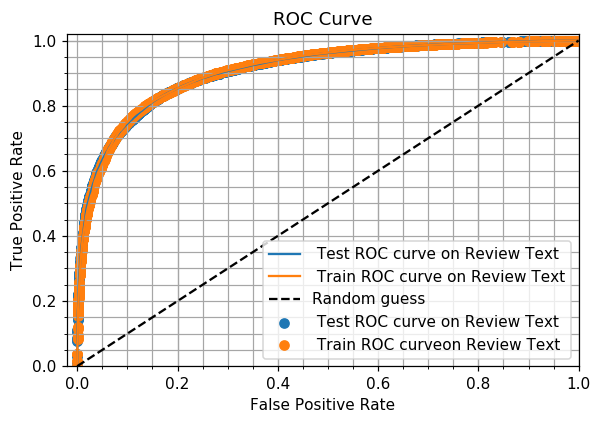

In [136]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avgwv_lin_SVM_l1, tpr_test_avgw2v_lin_SVM_l1, thresholds = roc_curve(y_test, proba_pred_lin_SVM_avgw2v_l1_test_pos)
fpr_train_avgw2v_lin_SVM_l1, tpr_train_avgw2v_lin_SVM_l1, thresholds = roc_curve(y_train, proba_pred_lin_SVM_avgw2v_l1_train_pos)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avgwv_lin_SVM_l1, tpr_test_avgw2v_lin_SVM_l1, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avgwv_lin_SVM_l1, tpr_test_avgw2v_lin_SVM_l1, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avgw2v_lin_SVM_l1, tpr_train_avgw2v_lin_SVM_l1, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avgw2v_lin_SVM_l1, tpr_train_avgw2v_lin_SVM_l1, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [137]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, best_alpha_pred_test_SVM_txt_avg_w2v_l1))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, best_aplha_pred_train_SVM_txt_avg_w2v_l1))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.45      0.89      0.60     21261
          1       0.97      0.77      0.86     99648

avg / total       0.88      0.79      0.81    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.40      0.88      0.55     22681
          1       0.98      0.79      0.87    141791

avg / total       0.90      0.80      0.83    164472



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


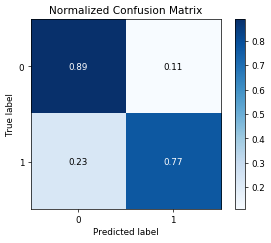

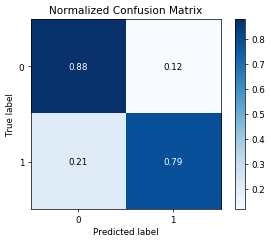

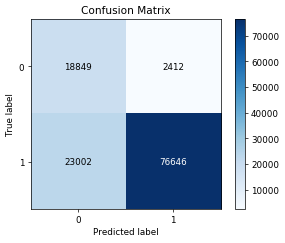

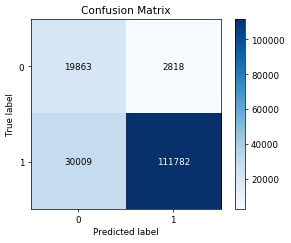

In [138]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_avg_w2v_l1,normalize=True)
skplt.plot_confusion_matrix(y_train,best_aplha_pred_train_SVM_txt_avg_w2v_l1,normalize=True)
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_avg_w2v_l1)
skplt.plot_confusion_matrix(y_train,best_aplha_pred_train_SVM_txt_avg_w2v_l1)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [46]:
model = TfidfVectorizer()
model.fit(X_no_stop_train)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names() # tfidf words/col-names


In [47]:
tfidf_w2v_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent4 in tqdm(lst_of_lst_train): # for each review/sentence 
    sent_vec4 = np.zeros(50) # as word vectors are of zero length
    weight_sum4 =0; # num of words with a valid vector in the sentence/review
    for word4 in sent4: # for each word in a review/sentence
        if word4 in w2v_words_train and word4 in tfidf_feat:
            vec4 = w2v_model_self_taught_train.wv[word4]
            tf_idf_train = dictionary[word4]*(sent4.count(word4)/len(sent4))
            sent_vec4 += (vec4 * tf_idf_train)
            weight_sum4 += tf_idf_train
    if weight_sum4 != 0:
        sent_vec4 /= weight_sum4
    tfidf_w2v_sent_vectors_train.append(sent_vec4)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164472/164472 [5:01:48<00:00, 10.12it/s]


In [48]:
tfidf_w2v_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent5 in tqdm(lst_of_lst_test): # for each review/sentence 
    sent_vec5 = np.zeros(50) # as word vectors are of zero length
    weight_sum5 =0; # num of words with a valid vector in the sentence/review
    for word5 in sent5: # for each word in a review/sentence
        if word5 in w2v_words_train and word5 in tfidf_feat:
            vec5 = w2v_model_self_taught_train.wv[word5]
            tf_idf_test = dictionary[word5]*(sent5.count(word5)/len(sent5))
            sent_vec5 += (vec5 * tf_idf_test)
            weight_sum5 += tf_idf_test
    if weight_sum5 != 0:
        sent_vec5 /= weight_sum5
    tfidf_w2v_sent_vectors_test.append(sent_vec5)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120909/120909 [3:45:51<00:00, 15.72it/s]


In [49]:
tfidf_w2v_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent6 in tqdm(lst_of_lst_CV): # for each review/sentence 
    sent_vec6 = np.zeros(50) # as word vectors are of zero length
    weight_sum6 =0; # num of words with a valid vector in the sentence/review
    for word6 in sent6: # for each word in a review/sentence
        if word6 in w2v_words_train and word6 in tfidf_feat:
            vec6 = w2v_model_self_taught_train.wv[word6]
            tf_idf_cv = dictionary[word6]*(sent6.count(word6)/len(sent6))
            sent_vec6 += (vec6 * tf_idf_cv)
            weight_sum6 += tf_idf_cv
    if weight_sum6 != 0:
        sent_vec6 /= weight_sum6
    tfidf_w2v_sent_vectors_cv.append(sent_vec6)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81009/81009 [2:28:51<00:00, 14.39it/s]


For backup purpose lets save 

In [50]:
tfidf_w2v_sent_vectors_train_copy=tfidf_w2v_sent_vectors_train
tfidf_w2v_sent_vectors_cv_copy = tfidf_w2v_sent_vectors_cv
tfidf_w2v_sent_vectors_test_copy = tfidf_w2v_sent_vectors_test

tfidf_w2v_sent_vectors_train_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_train)
tfidf_w2v_sent_vectors_test_std = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_test)
tfidf_w2v_sent_vectors_cv_std = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_cv)

In [128]:
def tothepower(y):
    return (10**y)
hyperparam_SVM = list(map(tothepower, list(range(-5, 5))))
print (hyperparam_SVM)
hyperparam_SVM_log = [math.log(x) for x in hyperparam_SVM]
print (hyperparam_SVM_log)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
[-11.512925464970229, -9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


In [129]:
from sklearn.linear_model import SGDClassifier
auc_cv_tfidf_w2v_txt_svm_l1 = []
auc_train_tfidf_w2v_txt_svm_l1=[]

for hyperpara in tqdm(hyperparam_SVM):
    SVM_tfidf_w2v_txt_l1 = SGDClassifier(loss='hinge',penalty='l1',alpha=hyperpara,class_weight="balanced")
    SVM_tfidf_w2v_txt_l1.fit(tfidf_w2v_sent_vectors_train_std, y_train)
    pred_train_SVM_txt_tfidf_w2v_l1=(SVM_tfidf_w2v_txt_l1.predict(tfidf_w2v_sent_vectors_train_std))
    pred_cv_SVM_txt_tfidf_w2v_l1=(SVM_tfidf_w2v_txt_l1.predict(tfidf_w2v_sent_vectors_cv_std))
    auc_train_tfidf_w2v_txt_svm_l1.append(roc_auc_score(y_train,pred_train_SVM_txt_tfidf_w2v_l1))
    auc_cv_tfidf_w2v_txt_svm_l1.append(roc_auc_score(y_CV,pred_cv_SVM_txt_tfidf_w2v_l1))
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.65it/s]


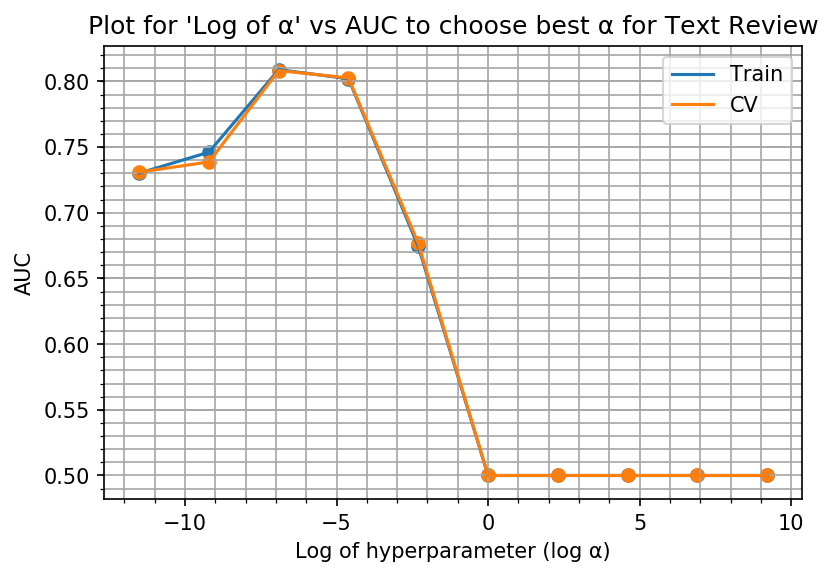

In [130]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(hyperparam_SVM_log, auc_train_tfidf_w2v_txt_svm_l1)
plt.scatter(hyperparam_SVM_log, auc_train_tfidf_w2v_txt_svm_l1)
plt.plot(hyperparam_SVM_log, auc_cv_tfidf_w2v_txt_svm_l1)
plt.scatter(hyperparam_SVM_log, auc_cv_tfidf_w2v_txt_svm_l1)
plt.xlabel('Log of hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'Log of α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [131]:
import numpy as np
lis_svm_avg_w2v = np.arange (.0001, .01, .0005)
print (lis_svm_avg_w2v)

[0.0001 0.0006 0.0011 0.0016 0.0021 0.0026 0.0031 0.0036 0.0041 0.0046
 0.0051 0.0056 0.0061 0.0066 0.0071 0.0076 0.0081 0.0086 0.0091 0.0096]


In [132]:
from sklearn.linear_model import SGDClassifier
auc_cv_tfidf_w2v_txt_svm_l1 = []
auc_train_tfidf_w2v_txt_svm_l1=[]

for hyperpara in tqdm(lis_svm_avg_w2v):
    SVM_tfidf_w2v_txt_l1 = SGDClassifier(loss='hinge',penalty='l1',alpha=hyperpara,class_weight="balanced")
    SVM_tfidf_w2v_txt_l1.fit(tfidf_w2v_sent_vectors_train_std, y_train)
    pred_train_SVM_txt_tfidf_w2v_l1=(SVM_tfidf_w2v_txt_l1.predict(tfidf_w2v_sent_vectors_train_std))
    pred_cv_SVM_txt_tfidf_w2v_l1=(SVM_tfidf_w2v_txt_l1.predict(tfidf_w2v_sent_vectors_cv_std))
    auc_train_tfidf_w2v_txt_svm_l1.append(roc_auc_score(y_train,pred_train_SVM_txt_tfidf_w2v_l1))
    auc_cv_tfidf_w2v_txt_svm_l1.append(roc_auc_score(y_CV,pred_cv_SVM_txt_tfidf_w2v_l1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14it/s]


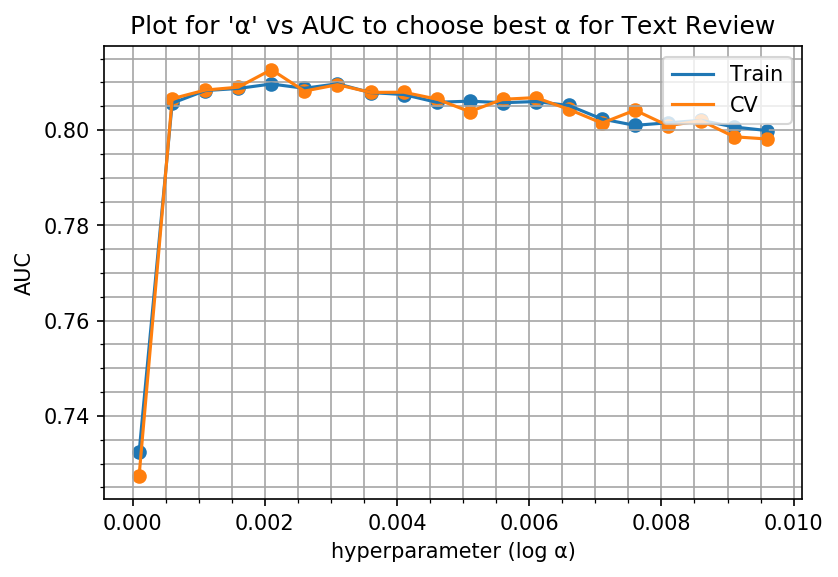

In [133]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis_svm_avg_w2v, auc_train_tfidf_w2v_txt_svm_l1)
plt.scatter(lis_svm_avg_w2v, auc_train_tfidf_w2v_txt_svm_l1)
plt.plot(lis_svm_avg_w2v, auc_cv_tfidf_w2v_txt_svm_l1)
plt.scatter(lis_svm_avg_w2v, auc_cv_tfidf_w2v_txt_svm_l1)
plt.xlabel('hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

The best value for α is 0.0016

In [145]:
SVM_tfidf_w2v_txt_l1 = SGDClassifier(loss='hinge',penalty='l1',alpha=0.0016,class_weight="balanced")
SVM_tfidf_w2v_txt_l1.fit(tfidf_w2v_sent_vectors_train_std, y_train)
best_alpha_pred_train_SVM_txt_tfidf_w2v_l1=(SVM_tfidf_w2v_txt_l1.predict(tfidf_w2v_sent_vectors_train_std))
best_alpha_pred_test_SVM_txt_tfidf_w2v_l1=(SVM_tfidf_w2v_txt_l1.predict(tfidf_w2v_sent_vectors_test_std))

In [167]:
l1_auc_test_tfidf_w2v_lin_SVM = roc_auc_score(y_test, best_alpha_pred_test_SVM_txt_tfidf_w2v_l1)
l1_auc_train_tfidf_w2v_lin_SVM = roc_auc_score(y_train, best_alpha_pred_train_SVM_txt_tfidf_w2v_l1)
print (l1_auc_test_tfidf_w2v_lin_SVM)
print (l1_auc_train_tfidf_w2v_lin_SVM)

0.8045406029307826
0.8100212768362935


In [51]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

SVM_tfidf_w2v_l1 = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l1',alpha=0.0016,class_weight="balanced"),method='isotonic',cv=2)
SVM_tfidf_w2v_l1.fit(tfidf_w2v_sent_vectors_train_std, y_train)
proba_pred_lin_SVM_tfidfw2v_l1_train = SVM_tfidf_w2v_l1.predict_proba(tfidf_w2v_sent_vectors_train_std)
proba_pred_lin_SVM_tfidfw2v_l1_test = SVM_tfidf_w2v_l1.predict_proba(tfidf_w2v_sent_vectors_test_std)
proba_pred_lin_SVM_tfidfw2v_l1_train_pos = proba_pred_lin_SVM_tfidfw2v_l1_train[:,1]
proba_pred_lin_SVM_tfidfw2v_l1_test_pos =  proba_pred_lin_SVM_tfidfw2v_l1_test[:,1]

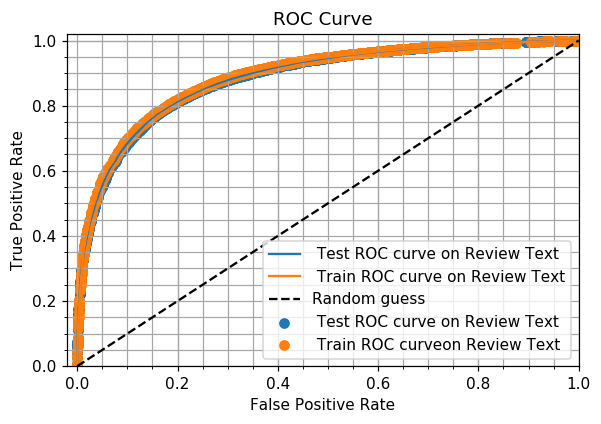

In [52]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidfw2v_lin_SVM_l1, tpr_test_tfidfw2v_lin_SVM_l1, thresholds = roc_curve(y_test, proba_pred_lin_SVM_tfidfw2v_l1_test_pos)
fpr_train_tfidfw2v_lin_SVM_l1, tpr_train_tfidfw2v_lin_SVM_l1, thresholds = roc_curve(y_train, proba_pred_lin_SVM_tfidfw2v_l1_train_pos)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidfw2v_lin_SVM_l1, tpr_test_tfidfw2v_lin_SVM_l1, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidfw2v_lin_SVM_l1, tpr_test_tfidfw2v_lin_SVM_l1, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidfw2v_lin_SVM_l1, tpr_train_tfidfw2v_lin_SVM_l1, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidfw2v_lin_SVM_l1, tpr_train_tfidfw2v_lin_SVM_l1, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [147]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, best_alpha_pred_test_SVM_txt_tfidf_w2v_l1))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, best_alpha_pred_train_SVM_txt_tfidf_w2v_l1))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.43      0.85      0.57     21261
          1       0.96      0.76      0.85     99648

avg / total       0.87      0.78      0.80    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.38      0.84      0.52     22681
          1       0.97      0.78      0.86    141791

avg / total       0.89      0.79      0.82    164472



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


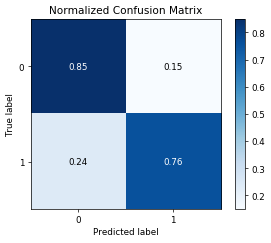

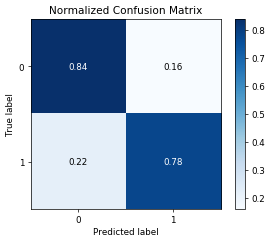

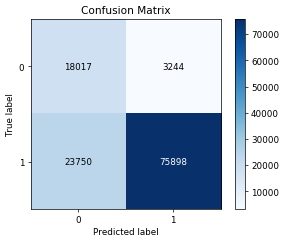

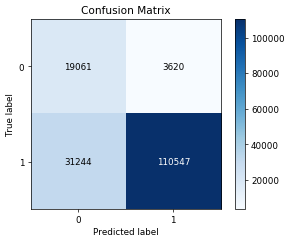

In [148]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_tfidf_w2v_l1,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_tfidf_w2v_l1,normalize=True)
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_tfidf_w2v_l1)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_tfidf_w2v_l1)


#### Now lets perform for L2

In [138]:
from sklearn.linear_model import SGDClassifier
auc_cv_tfidf_w2v_txt_svm_l2 = []
auc_train_tfidf_w2v_txt_svm_l2=[]

for hyperpara in tqdm(hyperparam_SVM):
    SVM_tfidf_w2v_txt_l2 = SGDClassifier(loss='hinge',penalty='l2',alpha=hyperpara,class_weight="balanced")
    SVM_tfidf_w2v_txt_l2.fit(tfidf_w2v_sent_vectors_train_std, y_train)
    pred_train_SVM_txt_tfidf_w2v_l2=(SVM_tfidf_w2v_txt_l2.predict(tfidf_w2v_sent_vectors_train_std))
    pred_cv_SVM_txt_tfidf_w2v_l2=(SVM_tfidf_w2v_txt_l2.predict(tfidf_w2v_sent_vectors_cv_std))
    auc_train_tfidf_w2v_txt_svm_l2.append(roc_auc_score(y_train,pred_train_SVM_txt_tfidf_w2v_l2))
    auc_cv_tfidf_w2v_txt_svm_l2.append(roc_auc_score(y_CV,pred_cv_SVM_txt_tfidf_w2v_l2))    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.99it/s]


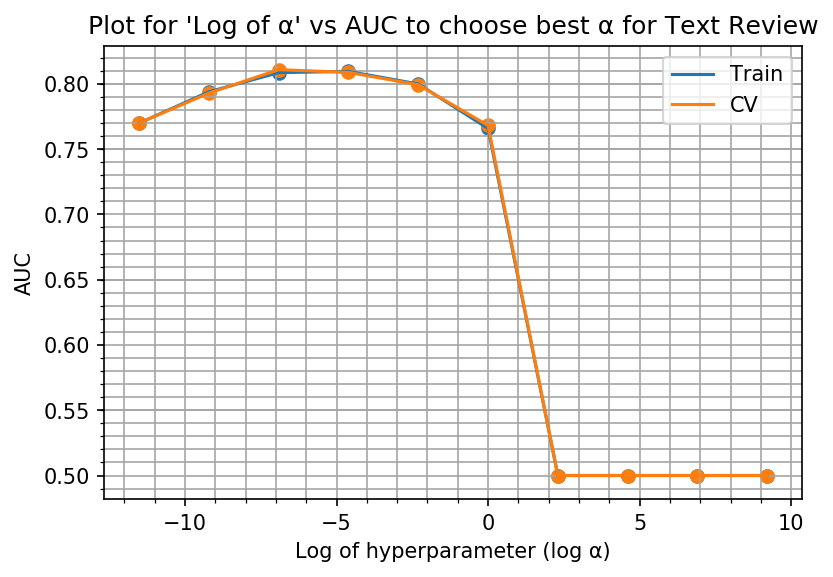

In [139]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(hyperparam_SVM_log, auc_train_tfidf_w2v_txt_svm_l2)
plt.scatter(hyperparam_SVM_log, auc_train_tfidf_w2v_txt_svm_l2)
plt.plot(hyperparam_SVM_log, auc_cv_tfidf_w2v_txt_svm_l2)
plt.scatter(hyperparam_SVM_log, auc_cv_tfidf_w2v_txt_svm_l2)
plt.xlabel('Log of hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'Log of α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

In [140]:
import numpy as np
lis_svm_avg_w2v_l2 = np.arange (.001, .1, .005)
print (lis_svm_avg_w2v_l2)

[0.001 0.006 0.011 0.016 0.021 0.026 0.031 0.036 0.041 0.046 0.051 0.056
 0.061 0.066 0.071 0.076 0.081 0.086 0.091 0.096]


In [141]:
from sklearn.linear_model import SGDClassifier
auc_cv_tfidf_w2v_txt_svm_l2 = []
auc_train_tfidf_w2v_txt_svm_l2=[]

for hyperpara in tqdm(lis_svm_avg_w2v_l2):
    SVM_tfidf_w2v_txt_l2 = SGDClassifier(loss='hinge',penalty='l2',alpha=hyperpara,class_weight="balanced")
    SVM_tfidf_w2v_txt_l2.fit(tfidf_w2v_sent_vectors_train_std, y_train)
    pred_train_SVM_txt_tfidf_w2v_l2=(SVM_tfidf_w2v_txt_l2.predict(tfidf_w2v_sent_vectors_train_std))
    pred_cv_SVM_txt_tfidf_w2v_l2=(SVM_tfidf_w2v_txt_l2.predict(tfidf_w2v_sent_vectors_cv_std))
    auc_train_tfidf_w2v_txt_svm_l2.append(roc_auc_score(y_train,pred_train_SVM_txt_tfidf_w2v_l2))
    auc_cv_tfidf_w2v_txt_svm_l2.append(roc_auc_score(y_CV,pred_cv_SVM_txt_tfidf_w2v_l2))    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


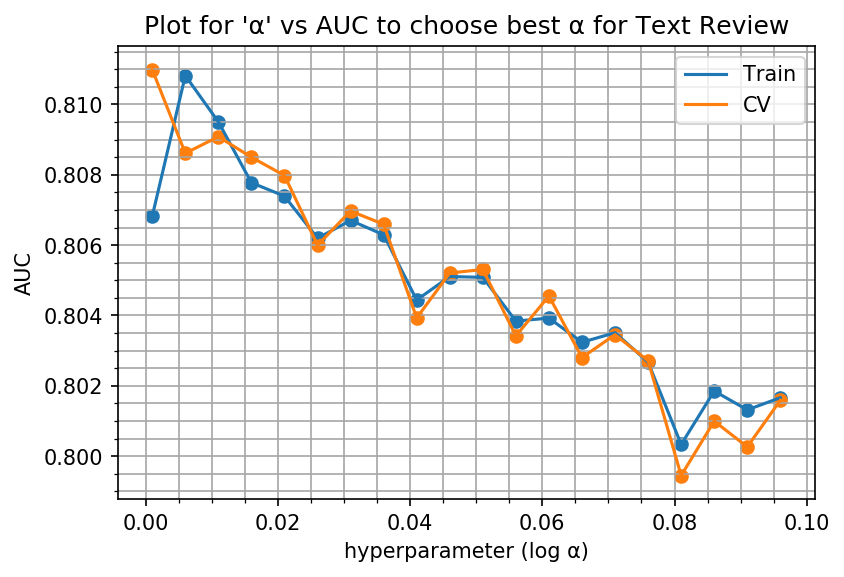

In [142]:
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.5
plt.plot(lis_svm_avg_w2v_l2, auc_train_tfidf_w2v_txt_svm_l2)
plt.scatter(lis_svm_avg_w2v_l2, auc_train_tfidf_w2v_txt_svm_l2)
plt.plot(lis_svm_avg_w2v_l2, auc_cv_tfidf_w2v_txt_svm_l2)
plt.scatter(lis_svm_avg_w2v_l2, auc_cv_tfidf_w2v_txt_svm_l2)
plt.xlabel('hyperparameter (log α)')
plt.ylabel('AUC')
plt.title("Plot for 'α' vs AUC to choose best α for Text Review")
plt.legend(['Train', 'CV'], loc='upper right')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

The best alpha is 0.011

In [149]:
SVM_tfidf_w2v_txt_l2 = SGDClassifier(loss='hinge',penalty='l2',alpha=.011,class_weight="balanced")
SVM_tfidf_w2v_txt_l2.fit(tfidf_w2v_sent_vectors_train_std, y_train)
best_alpha_pred_train_SVM_txt_tfidf_w2v_l2=(SVM_tfidf_w2v_txt_l2.predict(tfidf_w2v_sent_vectors_train_std))
best_alpha_pred_test_SVM_txt_tfidf_w2v_l2=(SVM_tfidf_w2v_txt_l2.predict(tfidf_w2v_sent_vectors_test_std))

In [166]:
l2_auc_test_tfidf_w2v_lin_SVM = roc_auc_score(y_test, best_alpha_pred_test_SVM_txt_tfidf_w2v_l2)
l2_auc_train_tfidf_w2v_lin_SVM = roc_auc_score(y_train, best_alpha_pred_train_SVM_txt_tfidf_w2v_l2)
print  (l2_auc_test_tfidf_w2v_lin_SVM)
print  (l2_auc_train_tfidf_w2v_lin_SVM)

0.8035759678215761
0.8098830570608501


In [53]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

SVM_tfidf_w2v_l2 = CalibratedClassifierCV(SGDClassifier(loss='hinge',penalty='l2',alpha=0.011,class_weight="balanced"),method='isotonic',cv=2)
SVM_tfidf_w2v_l2.fit(tfidf_w2v_sent_vectors_train_std, y_train)
proba_pred_lin_SVM_tfidfw2v_l2_train = SVM_tfidf_w2v_l2.predict_proba(tfidf_w2v_sent_vectors_train_std)
proba_pred_lin_SVM_tfidfw2v_l2_test = SVM_tfidf_w2v_l2.predict_proba(tfidf_w2v_sent_vectors_test_std)
proba_pred_lin_SVM_tfidfw2v_l2_train_pos = proba_pred_lin_SVM_tfidfw2v_l2_train[:,1]
proba_pred_lin_SVM_tfidfw2v_l2_test_pos =  proba_pred_lin_SVM_tfidfw2v_l2_test[:,1]

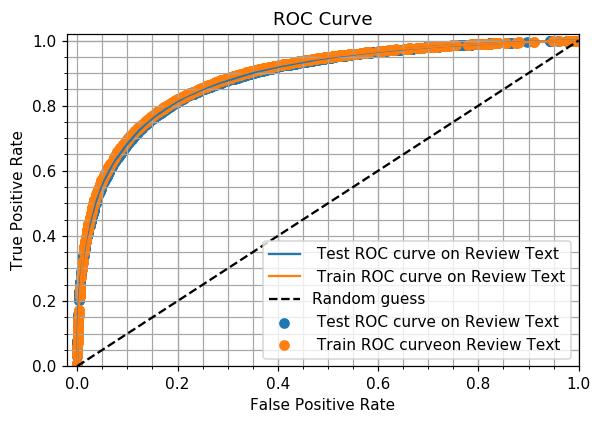

In [54]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidfw2v_lin_SVM_l2, tpr_test_tfidfw2v_lin_SVM_l2, thresholds = roc_curve(y_test, proba_pred_lin_SVM_tfidfw2v_l2_test_pos)
fpr_train_tfidfw2v_lin_SVM_l2, tpr_train_tfidfw2v_lin_SVM_l2, thresholds = roc_curve(y_train, proba_pred_lin_SVM_tfidfw2v_l2_train_pos)
# create plot
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidfw2v_lin_SVM_l2, tpr_test_tfidfw2v_lin_SVM_l2, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidfw2v_lin_SVM_l2, tpr_test_tfidfw2v_lin_SVM_l2, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidfw2v_lin_SVM_l2, tpr_train_tfidfw2v_lin_SVM_l2, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidfw2v_lin_SVM_l2, tpr_train_tfidfw2v_lin_SVM_l2, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [151]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test, best_alpha_pred_test_SVM_txt_tfidf_w2v_l2))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train, best_alpha_pred_train_SVM_txt_tfidf_w2v_l2))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.42      0.86      0.57     21261
          1       0.96      0.75      0.84     99648

avg / total       0.87      0.77      0.79    120909

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.37      0.85      0.52     22681
          1       0.97      0.77      0.86    141791

avg / total       0.89      0.78      0.81    164472



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


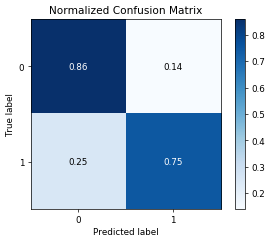

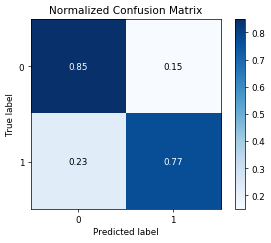

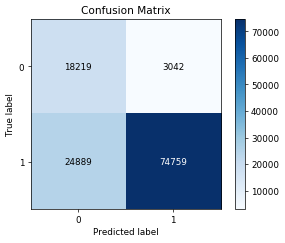

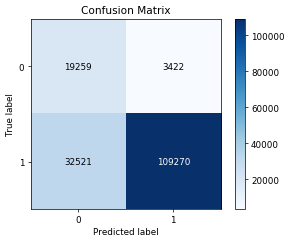

In [152]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_tfidf_w2v_l2,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_tfidf_w2v_l2,normalize=True)
skplt.plot_confusion_matrix(y_test,best_alpha_pred_test_SVM_txt_tfidf_w2v_l2)
skplt.plot_confusion_matrix(y_train,best_alpha_pred_train_SVM_txt_tfidf_w2v_l2)


## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

### Reference: https://www.kaggle.com/viznrvn/optimal-parameters-for-svc-using-gridsearch
#### http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html (HeatMap Test)

In [13]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)

# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)

#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Text"] =  (data["Text"].str.lower())
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Text'] = data['Text'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
##############Lets do the same for summary Text##################################
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
########################################################################################
# iii) Remove Special Characters except alpahbets and numbers
#The reason i dont want to remove number people might write got five eggs as 5 eggs or vice versa and dont want to lose 
#that information which could be useful
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Text"]=data["Text"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))
data["Summary_copy"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))

#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
#Ref:::::::::https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could','br','<br>','<','>']
notstopwords = ['not','no','nor']
stopwords.extend(newStopWords)
stopwords = [word for word in stopwords if word not in notstopwords]

#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Text"]= data['Text'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
data["Summary"]= data['Summary_copy'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])

#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Text"]=data["New_Text"].apply(' '.join)
data["Summary"]=data["Summary"].apply(' '.join)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Text"] = data["New_Text"].apply(english_stemmer.stem)
data["Summary"] = data["Summary"].apply(english_stemmer.stem)
data["New_Text"] = data["New_Text"].astype(str)
data["Summary"] = data["Summary"].astype(str)

#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Text_with_stop"]=data["Text"].astype(str)
data["Summary"]=data["Summary"].astype(str)
data["Text_with_stop"]=data["Text_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary"]=data["Summary"].str.lower().map(english_stemmer.stem)
data["Text_with_stop"]=data["Text_with_stop"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Text_with_stop"] = data["Text_with_stop"].astype(str)
data["Summary"] = data["Summary"].astype(str)
print(data["Score"].value_counts())
print ("Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced \
dataset we first copy negative dataset 6 times than we sample with same number of times as positive")
# Let include another feature which is the length of the text 
data_neg = data[data["Score"] == 0]
data_pos = data[data["Score"] == 1]
data = pd.concat([data_pos,data_neg])
#https://stackoverflow.com/questions/46429033/how-do-i-count-the-total-number-of-words-in-a-pandas-dataframe-cell-and-add-thos
data["Text_length"]= (data["New_Text"].str.count(' ') + 1)
data["Summary_length"]= (data["Summary"].str.count(' ') + 1)
data["Time_formatted"]= pd.to_datetime(data["Time"])
data.sort_values(by=['Time_formatted'], inplace=True)


Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
1    308679
0     57711
Name: Score, dtype: int64
Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced dataset we first copy negative dataset 6 times than we sample with same number of times as positive


In [14]:
newdata = data.tail(40000)
newdata.sort_values(by=['Time_formatted'], inplace=True)

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

Y_40k = newdata['Score'].values
X_no_stop_40k = newdata['New_Text'].values
X_summary_40k = newdata ['Summary'].values

X_no_stop_train_40k, X_no_stop_test_40k, y_train_40k, y_test_40k = train_test_split(X_no_stop_40k, Y_40k, test_size=0.33, shuffle=False)



In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import math

bow_vect_rbf = CountVectorizer(ngram_range = (1,2),min_df = 10,max_features=500)
bow_X_train_no_stop_rbf = bow_vect_rbf.fit_transform(X_no_stop_train_40k)
bow_X_test_no_stop_rbf = bow_vect_rbf.transform(X_no_stop_test_40k)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score



In [17]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

bow_X_train_no_stop_rbf_std =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_train_no_stop_rbf)
bow_X_test_no_stop_rbf_std = StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_test_no_stop_rbf)


In [18]:
from sklearn.svm import SVC
from sklearn import svm, grid_search
from sklearn.grid_search import GridSearchCV

param_grid = {'C':[10000,1000,100,10,1,0.1,0.01,0.001,0.0001],'gamma':[10000,1000,100,10,1,0.1,0.01,0.001,0.0001], 'kernel':['rbf']}
grid = GridSearchCV(SVC(),param_grid,scoring='roc_auc',cv=3, verbose=2)
grid.fit(bow_X_train_no_stop_rbf_std,y_train_40k)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf - 9.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min remaining:    0.0s


[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf - 9.0min
[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf - 9.4min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf - 9.3min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf - 9.2min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf - 9.3min
[CV] C=10000, gamma=100, kernel=rbf ..................................
[CV] ......................... C=10000, gamma=100, kernel=rbf - 8.7min
[CV] C=10000, gamma=100, kernel=rbf ..................................
[CV] ......................... C=10000, gamma=100, kernel=rbf - 8.8min
[CV] C

[CV] .......................... C=100, gamma=1000, kernel=rbf - 8.6min
[CV] C=100, gamma=1000, kernel=rbf ...................................
[CV] .......................... C=100, gamma=1000, kernel=rbf - 8.9min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 8.6min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 8.7min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 8.9min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] ............................ C=100, gamma=10, kernel=rbf - 7.7min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] ............................ C=100, gamma=10, kernel=rbf - 7.8min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] .

[CV] C=1, gamma=100, kernel=rbf ......................................
[CV] ............................. C=1, gamma=100, kernel=rbf - 7.1min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 5.7min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 5.8min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 5.5min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 5.0min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 5.2min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 5.4min
[CV] C

[CV] ........................... C=0.01, gamma=10, kernel=rbf - 2.9min
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf - 2.7min
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf - 2.7min
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf - 2.8min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf - 1.6min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf - 1.7min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf - 1.6min
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] .

[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  38.0s
[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  38.1s
[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  41.2s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  40.7s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  37.8s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  37.7s
[CV] C=0.0001, gamma=0.001, kernel=rbf ...............................
[CV] ...................... C=0.0001, gamma=0.001, kernel=rbf -  34.1s
[CV] C

[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 886.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'gamma': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [19]:
grid.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [21]:
from sklearn.svm import SVC
from sklearn import svm, grid_search

model_bow_rbf_probab = SVC(C=10,kernel='rbf',gamma=.01,probability=True,class_weight='balanced').fit(bow_X_train_no_stop_rbf_std,y_train_40k)
predictedprob_bow_rbf_test = (model_bow_rbf_probab.predict_proba(bow_X_test_no_stop_rbf_std)[:,1])
predictedprob_bow_rbf_train = (model_bow_rbf_probab.predict_proba(bow_X_train_no_stop_rbf_std)[:,1])


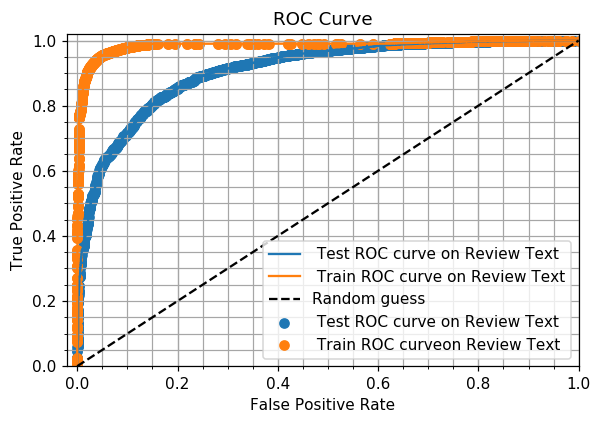

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_rbf, tpr_test_bow_rbf, thresholds = roc_curve(y_test_40k, predictedprob_bow_rbf_test)
fpr_train_bow_rbf, tpr_train_bow_rbf, thresholds = roc_curve(y_train_40k, predictedprob_bow_rbf_train)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_rbf, tpr_test_bow_rbf, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_bow_rbf, tpr_test_bow_rbf, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_bow_rbf, tpr_train_bow_rbf, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_bow_rbf, tpr_train_bow_rbf, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [23]:
C_range =[10000,1000,100,10,1,0.1,0.01,0.001,0.0001]
gamma_range = [10000,1000,100,10,1,0.1,0.01,0.001,0.0001]

In [24]:
print (grid.grid_scores_)

[mean: 0.50141, std: 0.00090, params: {'C': 10000, 'gamma': 10000, 'kernel': 'rbf'}, mean: 0.50141, std: 0.00090, params: {'C': 10000, 'gamma': 1000, 'kernel': 'rbf'}, mean: 0.50141, std: 0.00090, params: {'C': 10000, 'gamma': 100, 'kernel': 'rbf'}, mean: 0.50358, std: 0.00145, params: {'C': 10000, 'gamma': 10, 'kernel': 'rbf'}, mean: 0.71882, std: 0.00361, params: {'C': 10000, 'gamma': 1, 'kernel': 'rbf'}, mean: 0.85566, std: 0.00293, params: {'C': 10000, 'gamma': 0.1, 'kernel': 'rbf'}, mean: 0.85387, std: 0.00410, params: {'C': 10000, 'gamma': 0.01, 'kernel': 'rbf'}, mean: 0.86420, std: 0.00659, params: {'C': 10000, 'gamma': 0.001, 'kernel': 'rbf'}, mean: 0.89508, std: 0.00339, params: {'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}, mean: 0.50141, std: 0.00090, params: {'C': 1000, 'gamma': 10000, 'kernel': 'rbf'}, mean: 0.50141, std: 0.00090, params: {'C': 1000, 'gamma': 1000, 'kernel': 'rbf'}, mean: 0.50141, std: 0.00090, params: {'C': 1000, 'gamma': 100, 'kernel': 'rbf'}, mean: 0.5

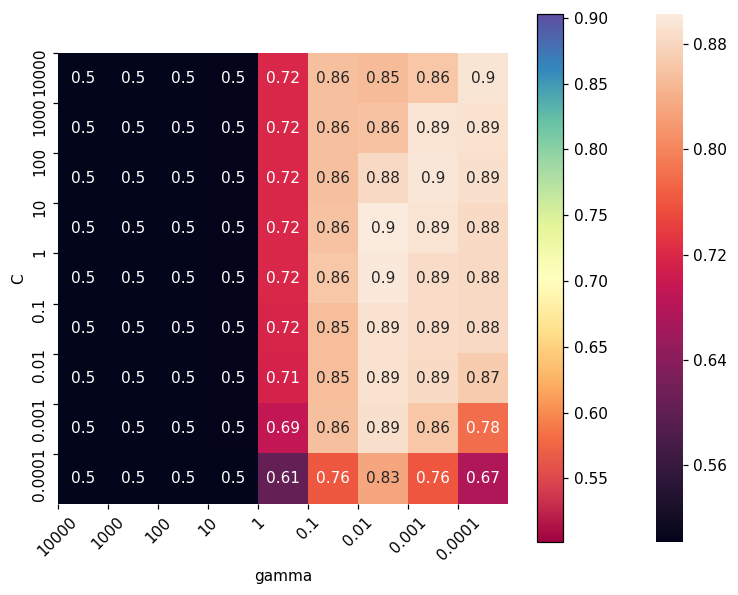

In [26]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm
import seaborn as sns

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = grid.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('gamma')
pl.ylabel('C')
pl.colorbar()
pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
pl.yticks(np.arange(len(C_range)), C_range)
pl.grid(False)
pl.show()


In [29]:
model_bow_rbf = SVC(C=10,kernel='rbf',gamma=.01,class_weight='balanced').fit(bow_X_train_no_stop_rbf_std,y_train_40k)


In [30]:
from sklearn.metrics import roc_auc_score
predictions_rbf_bow_train = model_bow_rbf.predict(bow_X_train_no_stop_rbf_std)
predictions_rbf_bow_test = model_bow_rbf.predict(bow_X_test_no_stop_rbf_std)

rbf_bow_auc_train = roc_auc_score(y_train_40k, predictions_rbf_bow_train)
rbf_bow_auc_test = roc_auc_score(y_test_40k, predictions_rbf_bow_test)

In [31]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predictions_rbf_bow_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predictions_rbf_bow_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.57      0.75      0.65      2156
          1       0.95      0.89      0.92     11044

avg / total       0.89      0.87      0.87     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.75      0.97      0.84      4707
          1       0.99      0.93      0.96     22093

avg / total       0.95      0.94      0.94     26800



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


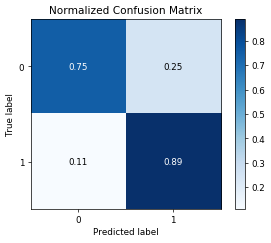

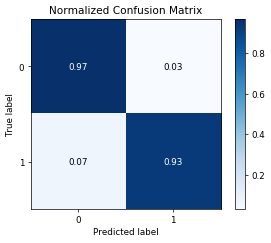

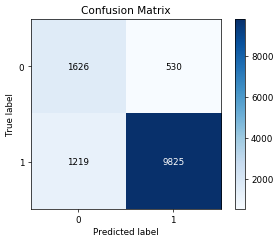

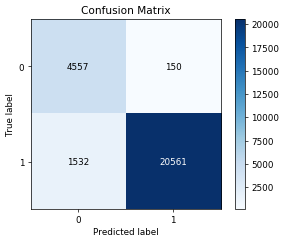

In [32]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_test_40k, predictions_rbf_bow_test,normalize=True)
skplt.plot_confusion_matrix(y_train_40k, predictions_rbf_bow_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predictions_rbf_bow_test)
skplt.plot_confusion_matrix(y_train_40k, predictions_rbf_bow_train)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler


tf_idf_vect = TfidfVectorizer(ngram_range=(1,5),min_df = 10,max_features=500)
tfidf_X_train_40k = tf_idf_vect.fit_transform(X_no_stop_train_40k)
tfidf_X_test_40k = tf_idf_vect.transform(X_no_stop_test_40k)

tfidf_X_train_40k_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_train_40k)
tfidf_X_test_40k_std = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_test_40k)


In [34]:
grid_tfidf = GridSearchCV(SVC(),param_grid,scoring='roc_auc',cv=3, verbose=2)
grid_tfidf.fit(tfidf_X_train_40k_std,y_train_40k)
grid_tfidf.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf -33.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 33.3min remaining:    0.0s


[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf -35.5min
[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf -34.9min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf -33.3min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf -31.1min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf -31.9min
[CV] C=10000, gamma=100, kernel=rbf ..................................
[CV] ......................... C=10000, gamma=100, kernel=rbf -24.9min
[CV] C=10000, gamma=100, kernel=rbf ..................................
[CV] ......................... C=10000, gamma=100, kernel=rbf -24.8min
[CV] C

[CV] .......................... C=100, gamma=1000, kernel=rbf -10.7min
[CV] C=100, gamma=1000, kernel=rbf ...................................
[CV] .......................... C=100, gamma=1000, kernel=rbf -10.7min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 8.6min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 9.3min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 8.9min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] ............................ C=100, gamma=10, kernel=rbf - 8.5min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] ............................ C=100, gamma=10, kernel=rbf - 9.0min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] .

[CV] C=1, gamma=100, kernel=rbf ......................................
[CV] ............................. C=1, gamma=100, kernel=rbf - 6.6min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 6.7min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 6.8min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 6.2min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 1.1min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 1.2min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 1.2min
[CV] C

[CV] ........................... C=0.01, gamma=10, kernel=rbf - 2.9min
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf -  50.9s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf -  55.5s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf - 1.0min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf -  57.1s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf -  59.0s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf -  54.9s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] .

[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  34.7s
[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  35.0s
[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  34.9s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  33.8s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  34.1s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  34.2s
[CV] C=0.0001, gamma=0.001, kernel=rbf ...............................
[CV] ...................... C=0.0001, gamma=0.001, kernel=rbf -  34.0s
[CV] C

[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 1084.6min finished


{'C': 10000, 'gamma': 1, 'kernel': 'rbf'}

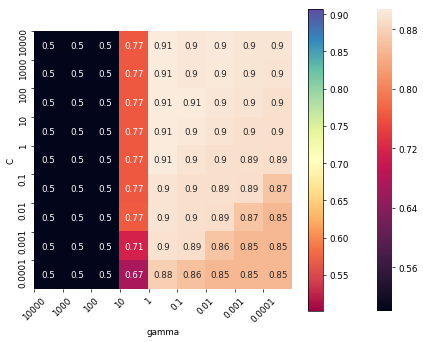

In [35]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm


# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_tfidf = grid_tfidf.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_tfidf]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('gamma')
pl.ylabel('C')
pl.colorbar()
pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
pl.yticks(np.arange(len(C_range)), C_range)
pl.show()

In [45]:
from sklearn.svm import SVC
from sklearn import svm, grid_search

model_tfidf_rbf_probab = SVC(C=10000,kernel='rbf',gamma=1,probability=True,class_weight='balanced').fit(tfidf_X_train_40k_std,y_train_40k)
predictedprob_tfidf_rbf_test = (model_tfidf_rbf_probab.predict_proba(tfidf_X_test_40k_std)[:,1])
predictedprob_tfidf_rbf_train = (model_tfidf_rbf_probab.predict_proba(tfidf_X_train_40k_std)[:,1])


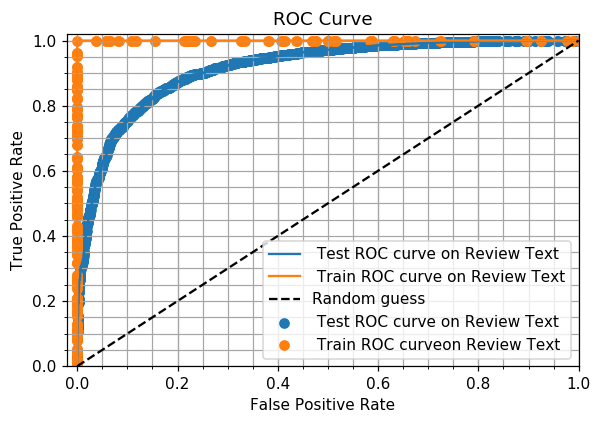

In [46]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidf_rbf, tpr_test_tfidf_rbf, thresholds = roc_curve(y_test_40k, predictedprob_tfidf_rbf_test)
fpr_train_tfidf_rbf, tpr_train_tfidf_rbf, thresholds = roc_curve(y_train_40k, predictedprob_tfidf_rbf_train)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidf_rbf, tpr_test_tfidf_rbf, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidf_rbf, tpr_test_tfidf_rbf, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidf_rbf, tpr_train_tfidf_rbf, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidf_rbf, tpr_train_tfidf_rbf, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [47]:
from sklearn.metrics import roc_auc_score
predictions_rbf_tfidf_train = grid_tfidf.predict(tfidf_X_train_40k_std)
predictions_rbf_tfidf_test = grid_tfidf.predict(tfidf_X_test_40k_std)

rbf_tfidf_auc_train = roc_auc_score(y_train_40k, predictions_rbf_tfidf_train)
rbf_tfidf_auc_test =  roc_auc_score(y_test_40k, predictions_rbf_tfidf_test)

In [48]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predictions_rbf_tfidf_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predictions_rbf_tfidf_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.74      0.56      0.64      2156
          1       0.92      0.96      0.94     11044

avg / total       0.89      0.90      0.89     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4707
          1       1.00      1.00      1.00     22093

avg / total       1.00      1.00      1.00     26800



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


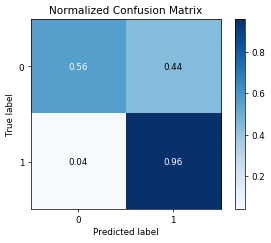

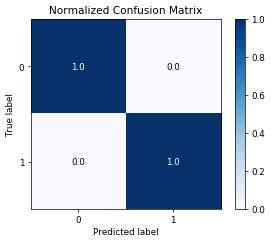

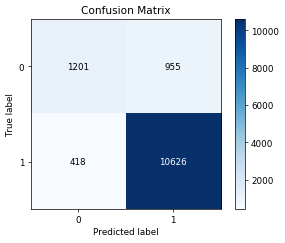

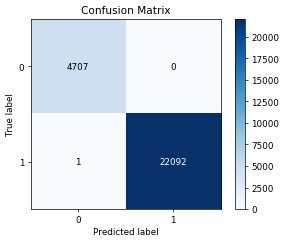

In [49]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predictions_rbf_tfidf_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predictions_rbf_tfidf_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predictions_rbf_tfidf_test)
skplt.plot_confusion_matrix(y_train_40k, predictions_rbf_tfidf_train)


### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [36]:
lst_train_rbf=[]
lst_test_rbf=[]
lst_of_lst_train_rbf = []
lst_of_lst_test_rbf = []
lst_of_lst_CV_rbf =[]
lst_CV_rbf = []

for sentance in tqdm(X_no_stop_train_40k):
    lst_train_rbf.append(sentance.strip())
for sentance in tqdm(lst_train_rbf):
    lst_of_lst_train_rbf.append(sentance.split())

for sent in tqdm(X_no_stop_test_40k):
    lst_test_rbf.append(sent.strip())
for sent in tqdm(lst_test_rbf):
    lst_of_lst_test_rbf.append(sent.split())
    
    
w2v_model_self_taught_train_rbf=Word2Vec(lst_of_lst_train_rbf,min_count=1,size=50, workers=4)
w2v_words_train_rbf = list(w2v_model_self_taught_train_rbf.wv.vocab)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13200/13200 [00:00<00:00, 140835.10it/s]


In [37]:
sent_vectors_train_l1_rbf = []
for sent1 in tqdm(lst_of_lst_train_rbf): # for each review/sentence
    sent_vec1 = np.zeros(50)
    cnt_words1 = 0
    for word1 in sent1:
        if word1 in w2v_words_train_rbf:
            vec1 = w2v_model_self_taught_train_rbf.wv[word1]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    sent_vectors_train_l1_rbf.append(sent_vec1) 

sent_vectors_test_l1_rbf = []
for sent2 in tqdm(lst_of_lst_test_rbf): # for each review/sentence
    sent_vec2 = np.zeros(50)
    cnt_words2 = 0
    for word2 in sent2:
        if word2 in w2v_words_train_rbf:
            vec2 = w2v_model_self_taught_train_rbf.wv[word2]
            sent_vec2 += vec2
            cnt_words2 += 1
    if cnt_words2 != 0:
        sent_vec2 /= cnt_words2
    sent_vectors_test_l1_rbf.append(sent_vec2)


from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sent_vectors_train_std =StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_train_l1_rbf)
sent_vectors_test_std = StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_test_l1_rbf)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13200/13200 [00:55<00:00, 239.86it/s]


In [38]:
grid_avg_w2v = GridSearchCV(SVC(),param_grid,cv=3, verbose=2)
grid_avg_w2v.fit(sent_vectors_train_std,y_train_40k)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf - 4.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s


[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf - 4.7min
[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf - 5.1min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf - 4.9min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf - 4.8min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf - 5.0min
[CV] C=10000, gamma=100, kernel=rbf ..................................
[CV] ......................... C=10000, gamma=100, kernel=rbf - 4.4min
[CV] C=10000, gamma=100, kernel=rbf ..................................
[CV] ......................... C=10000, gamma=100, kernel=rbf - 4.3min
[CV] C

[CV] .......................... C=100, gamma=1000, kernel=rbf - 5.2min
[CV] C=100, gamma=1000, kernel=rbf ...................................
[CV] .......................... C=100, gamma=1000, kernel=rbf - 5.4min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 4.7min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 4.5min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 4.5min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] ............................ C=100, gamma=10, kernel=rbf - 3.0min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] ............................ C=100, gamma=10, kernel=rbf - 3.0min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] .

[CV] C=1, gamma=100, kernel=rbf ......................................
[CV] ............................. C=1, gamma=100, kernel=rbf - 3.7min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 2.3min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 2.3min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 2.3min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 1.4min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 1.3min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 1.3min
[CV] C

[CV] ........................... C=0.01, gamma=10, kernel=rbf - 1.1min
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf -  31.9s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf -  32.3s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf -  32.8s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf -  16.7s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf -  16.8s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf -  17.0s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] .

[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  15.6s
[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  15.6s
[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  15.7s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  14.1s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  13.8s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  14.0s
[CV] C=0.0001, gamma=0.001, kernel=rbf ...............................
[CV] ...................... C=0.0001, gamma=0.001, kernel=rbf -  13.3s
[CV] C

[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 401.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'gamma': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [62]:
grid_avg_w2v.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

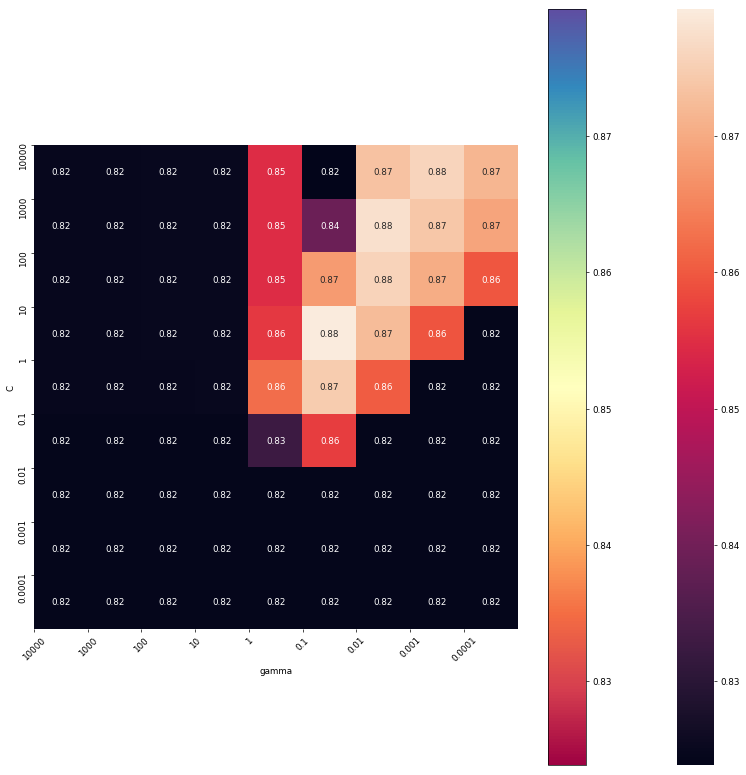

In [61]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm


# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_avg_w2v = grid_avg_w2v.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_avg_w2v]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Make a nice figure
pl.figure(figsize=(15, 15))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('gamma')
pl.ylabel('C')
pl.colorbar()
pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
pl.yticks(np.arange(len(C_range)), C_range)
pl.show()

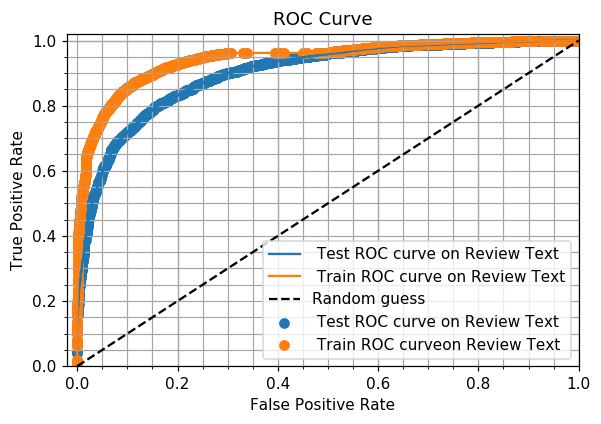

In [63]:
from sklearn.svm import SVC
from sklearn import svm, grid_search

model_avgw2v_rbf_probab = SVC(C=10,kernel='rbf',gamma=0.1,probability=True,class_weight='balanced').fit(sent_vectors_train_std,y_train_40k)
predictedprob_avgw2v_rbf_test = (model_avgw2v_rbf_probab.predict_proba(sent_vectors_test_std)[:,1])
predictedprob_avgw2v_rbf_train = (model_avgw2v_rbf_probab.predict_proba(sent_vectors_train_std)[:,1])

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avgw2v_rbf, tpr_test_avgw2v_rbf, thresholds = roc_curve(y_test_40k, predictedprob_avgw2v_rbf_test)
fpr_train_avgw2v_rbf, tpr_train_avgw2v_rbf, thresholds = roc_curve(y_train_40k, predictedprob_avgw2v_rbf_train)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avgw2v_rbf, tpr_test_avgw2v_rbf, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avgw2v_rbf, tpr_test_avgw2v_rbf, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avgw2v_rbf, tpr_train_avgw2v_rbf, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avgw2v_rbf, tpr_train_avgw2v_rbf, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [64]:
from sklearn.metrics import roc_auc_score
predictions_rbf_avgw2v_train = grid_avg_w2v.predict(sent_vectors_train_std)
predictions_rbf_avgw2v_test = grid_avg_w2v.predict(sent_vectors_test_std)

rbf_avgw2v_auc_train = roc_auc_score(y_train_40k, predictions_rbf_avgw2v_train)
rbf_avgw2v_auc_test = roc_auc_score(y_test_40k, predictions_rbf_avgw2v_test)

print (rbf_avgw2v_auc_train)
print (rbf_avgw2v_auc_test)

0.7678031308464073
0.7265465041503745


In [65]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predictions_rbf_avgw2v_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predictions_rbf_avgw2v_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.75      0.48      0.59      2156
          1       0.91      0.97      0.94     11044

avg / total       0.88      0.89      0.88     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.83      0.56      0.67      4707
          1       0.91      0.98      0.94     22093

avg / total       0.90      0.90      0.89     26800



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


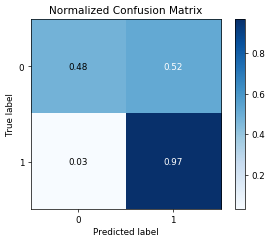

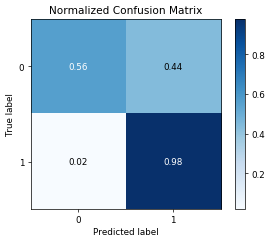

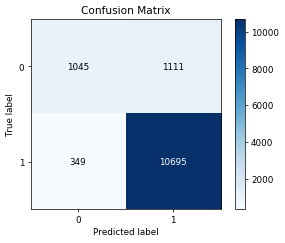

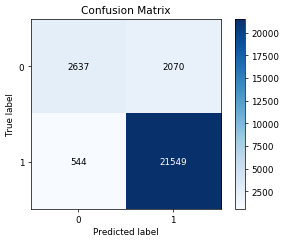

In [66]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predictions_rbf_avgw2v_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predictions_rbf_avgw2v_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predictions_rbf_avgw2v_test)
skplt.plot_confusion_matrix(y_train_40k, predictions_rbf_avgw2v_train)


### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [40]:
model_tfidfw2v = TfidfVectorizer()
model_tfidfw2v.fit(X_no_stop_train_40k)
dictionary = dict(zip(model_tfidfw2v.get_feature_names(), list(model_tfidfw2v.idf_)))
tfidf_feat_tfidfw2v = model_tfidfw2v.get_feature_names() # tfidf words/col-names


In [41]:
tfidf_w2v_sent_vectors_train_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent4 in tqdm(lst_of_lst_train_rbf): # for each review/sentence 
    sent_vec4 = np.zeros(50) # as word vectors are of zero length
    weight_sum4 =0; # num of words with a valid vector in the sentence/review
    for word4 in sent4: # for each word in a review/sentence
        if word4 in w2v_words_train_rbf and word4 in tfidf_feat_tfidfw2v:
            vec4 = w2v_model_self_taught_train_rbf.wv[word4]
            tf_idf_train = dictionary[word4]*(sent4.count(word4)/len(sent4))
            sent_vec4 += (vec4 * tf_idf_train)
            weight_sum4 += tf_idf_train
    if weight_sum4 != 0:
        sent_vec4 /= weight_sum4
    tfidf_w2v_sent_vectors_train_rbf.append(sent_vec4)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26800/26800 [10:31<00:00, 42.42it/s]


In [42]:
tfidf_w2v_sent_vectors_test_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent5 in tqdm(lst_of_lst_test_rbf): # for each review/sentence 
    sent_vec5 = np.zeros(50) # as word vectors are of zero length
    weight_sum5 =0; # num of words with a valid vector in the sentence/review
    for word5 in sent5: # for each word in a review/sentence
        if word5 in w2v_words_train_rbf and word5 in tfidf_feat_tfidfw2v:
            vec5 = w2v_model_self_taught_train_rbf.wv[word5]
            tf_idf_test = dictionary[word5]*(sent5.count(word5)/len(sent5))
            sent_vec5 += (vec5 * tf_idf_test)
            weight_sum5 += tf_idf_test
    if weight_sum5 != 0:
        sent_vec5 /= weight_sum5
    tfidf_w2v_sent_vectors_test_rbf.append(sent_vec5)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13200/13200 [04:56<00:00, 44.49it/s]


In [43]:
tfidf_w2v_sent_vectors_train_rbf_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_train_rbf)
tfidf_w2v_sent_vectors_test_rbf_std = StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_test_rbf)


In [44]:
grid_w2v_tfidf = GridSearchCV(SVC(),param_grid,cv=3, verbose=2)
grid_w2v_tfidf.fit(tfidf_w2v_sent_vectors_train_rbf,y_train_40k)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf - 4.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min remaining:    0.0s


[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf - 4.7min
[CV] C=10000, gamma=10000, kernel=rbf ................................
[CV] ....................... C=10000, gamma=10000, kernel=rbf - 5.1min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf - 4.9min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf - 5.2min
[CV] C=10000, gamma=1000, kernel=rbf .................................
[CV] ........................ C=10000, gamma=1000, kernel=rbf - 5.2min
[CV] C=10000, gamma=100, kernel=rbf ..................................
[CV] ......................... C=10000, gamma=100, kernel=rbf - 4.6min
[CV] C=10000, gamma=100, kernel=rbf ..................................
[CV] ......................... C=10000, gamma=100, kernel=rbf - 4.4min
[CV] C

[CV] .......................... C=100, gamma=1000, kernel=rbf - 4.8min
[CV] C=100, gamma=1000, kernel=rbf ...................................
[CV] .......................... C=100, gamma=1000, kernel=rbf - 5.0min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 4.5min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 4.4min
[CV] C=100, gamma=100, kernel=rbf ....................................
[CV] ........................... C=100, gamma=100, kernel=rbf - 4.6min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] ............................ C=100, gamma=10, kernel=rbf - 2.5min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] ............................ C=100, gamma=10, kernel=rbf - 2.5min
[CV] C=100, gamma=10, kernel=rbf .....................................
[CV] .

[CV] C=1, gamma=100, kernel=rbf ......................................
[CV] ............................. C=1, gamma=100, kernel=rbf - 3.2min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 2.0min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 2.0min
[CV] C=1, gamma=10, kernel=rbf .......................................
[CV] .............................. C=1, gamma=10, kernel=rbf - 2.0min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 1.1min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 1.1min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ............................... C=1, gamma=1, kernel=rbf - 1.1min
[CV] C

[CV] ........................... C=0.01, gamma=10, kernel=rbf - 1.1min
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf -  34.4s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf -  34.9s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ............................ C=0.01, gamma=1, kernel=rbf -  35.5s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf -  17.7s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf -  17.7s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .......................... C=0.01, gamma=0.1, kernel=rbf -  17.8s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] .

[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  15.9s
[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  15.2s
[CV] C=0.0001, gamma=0.1, kernel=rbf .................................
[CV] ........................ C=0.0001, gamma=0.1, kernel=rbf -  15.4s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  14.8s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  15.7s
[CV] C=0.0001, gamma=0.01, kernel=rbf ................................
[CV] ....................... C=0.0001, gamma=0.01, kernel=rbf -  16.4s
[CV] C=0.0001, gamma=0.001, kernel=rbf ...............................
[CV] ...................... C=0.0001, gamma=0.001, kernel=rbf -  14.4s
[CV] C

[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 395.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'gamma': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [56]:
grid_w2v_tfidf.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

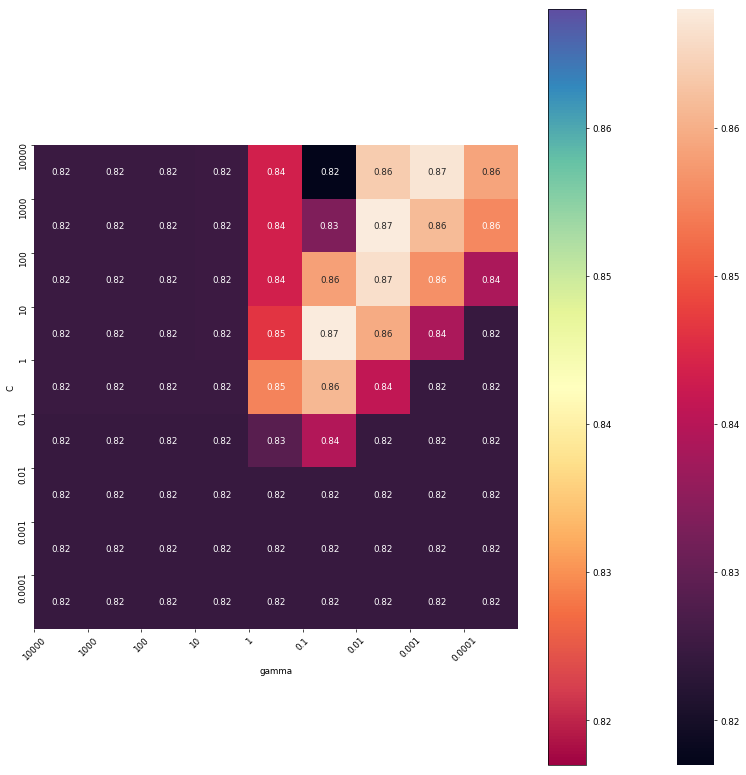

In [55]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm


# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_w2v_tfidf = grid_w2v_tfidf.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_w2v_tfidf]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Make a nice figure
pl.figure(figsize=(15, 15))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('gamma')
pl.ylabel('C')
pl.colorbar()
pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
pl.yticks(np.arange(len(C_range)), C_range)
pl.show()

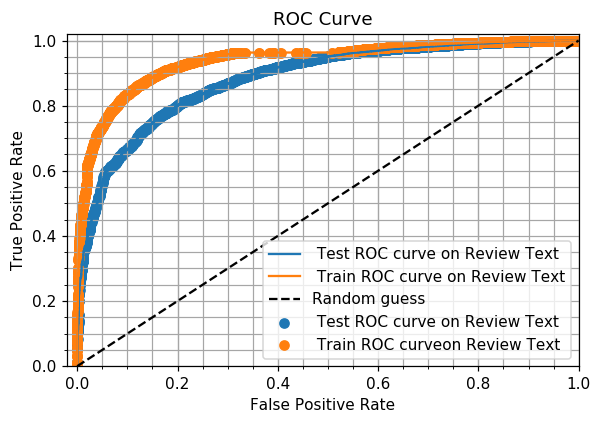

In [57]:
from sklearn.svm import SVC
from sklearn import svm, grid_search

model_tfidfw2v_rbf_probab = SVC(C=10,kernel='rbf',gamma=0.1,probability=True,class_weight='balanced').fit(tfidf_w2v_sent_vectors_train_rbf_std,y_train_40k)
predictedprob_tfidfw2v_rbf_test = (model_tfidfw2v_rbf_probab.predict_proba(tfidf_w2v_sent_vectors_test_rbf_std)[:,1])
predictedprob_tfidfw2v_rbf_train = (model_tfidfw2v_rbf_probab.predict_proba(tfidf_w2v_sent_vectors_train_rbf_std)[:,1])

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidfw2v_rbf, tpr_test_tfidfw2v_rbf, thresholds = roc_curve(y_test_40k, predictedprob_tfidfw2v_rbf_test)
fpr_train_tfidfw2v_rbf, tpr_train_tfidfw2v_rbf, thresholds = roc_curve(y_train_40k, predictedprob_tfidfw2v_rbf_train)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidfw2v_rbf, tpr_test_tfidfw2v_rbf, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidfw2v_rbf, tpr_test_tfidfw2v_rbf, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidfw2v_rbf, tpr_train_tfidfw2v_rbf, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidfw2v_rbf, tpr_train_tfidfw2v_rbf, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [58]:
from sklearn.metrics import roc_auc_score
predictions_rbf_tfidfw2v_train = grid_w2v_tfidf.predict(tfidf_w2v_sent_vectors_train_rbf)
predictions_rbf_tfidfw2v_test = grid_w2v_tfidf.predict(tfidf_w2v_sent_vectors_test_rbf)

rbf_tfidfw2v_auc_train = roc_auc_score(y_train_40k, predictions_rbf_tfidfw2v_train)
rbf_tfidfw2v_auc_test = roc_auc_score(y_test_40k, predictions_rbf_tfidfw2v_test)

The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


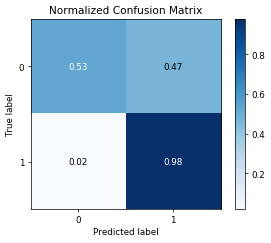

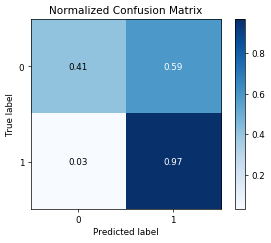

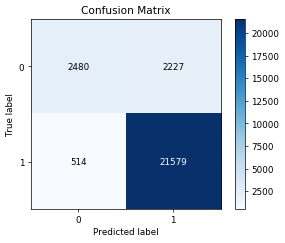

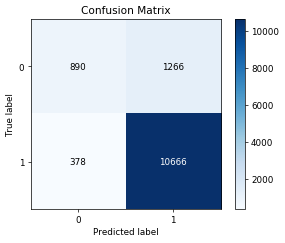

In [59]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_train_40k, predictions_rbf_tfidfw2v_train,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_test_40k, predictions_rbf_tfidfw2v_test,normalize=True)
skplt.plot_confusion_matrix(y_train_40k, predictions_rbf_tfidfw2v_train)
skplt.plot_confusion_matrix(y_test_40k, predictions_rbf_tfidfw2v_test)


In [60]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predictions_rbf_tfidfw2v_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predictions_rbf_tfidfw2v_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.70      0.41      0.52      2156
          1       0.89      0.97      0.93     11044

avg / total       0.86      0.88      0.86     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.83      0.53      0.64      4707
          1       0.91      0.98      0.94     22093

avg / total       0.89      0.90      0.89     26800



# [6] Conclusions

In [34]:
# Please compare all your models using Prettytable library

In [148]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Algorithm","Hyper-Parameter", "AUC"]

x.add_row(["Linear SVM BOW L2  Test", "α = 0.0006",l2_auc_test_BOW_lin_SVM])
x.add_row(["Linear SVM BOW L2 Train", "α = 0.0006",l2_auc_train_BOW_lin_SVM])
x.add_row(["Linear SVM BOW L1 Test", "α = 0.00001",l1_auc_test_BOW_lin_SVM])
x.add_row(["Linear SVM BOW L1 Train","α = 0.00001",l1_auc_train_BOW_lin_SVM])
x.add_row(["Linear SVM TFIDF  L2  Test", "α = 0.00001" ,l2_auc_test_tfidf_lin_SVM])
x.add_row(["Linear SVM TFIDF  L2 Train", "α = 0.00001" ,l2_auc_train_tfidf_lin_SVM])
x.add_row(["Linear SVM TFIDF  L1 Test", "α = 0.00001" ,l1_auc_test_tfidf_lin_SVM])
x.add_row(["Linear SVM TFIDF  L1 Train", "α = 0.00001" ,l1_auc_train_tfidf_lin_SVM])
x.add_row(["Linear SVM AVGW2V  L2 Test","α = 0.006", l2_auc_test_avgw2v_lin_SVM])
x.add_row(["Linear SVM AVGW2V  L2 Train","α = 0.006",l2_auc_train_avgw2v_lin_SVM])
x.add_row(["Linear SVM AVGW2V  L1 Test","α = 0.0006",l1_auc_test_avgw2v_lin_SVM])
x.add_row(["Linear SVM AVGW2V  L1 Train","α = 0.0006",l1_auc_train_avgw2v_lin_SVM])
x.add_row(["Linear SVM TFIDF-W2V with L2 (Test)","α = 0.011", 0.8035759678215761])
x.add_row(["Linear SVM TFIDF-W2V with L2 (Train)","α = 0.011",0.8098830570608501])
x.add_row(["Linear SVM TFIDF-W2V with L1 (Test)","α = 0.0016",0.8045406029307826])
x.add_row(["Linear SVM TFIDF-W2V with L1 (Train)","α = 0.0016",0.8100212768362935])
x.add_row(["RBF SVM BOW  Test", "C: 100 ; gamma: 0.001",rbf_bow_auc_test])
x.add_row(["RBF SVM BOW Train","C: 100 ; gamma: 0.001",rbf_bow_auc_train])
x.add_row(["RBF SVM TFIDF Test", 'C: 100 ;gamma: 0.1'  ,rbf_tfidf_auc_test])
x.add_row(["RBF SVM TFIDF Train", 'C: 100 ;gamma: 0.1' ,rbf_tfidf_auc_train])
x.add_row(["RBF SVM AVGW2V  Test", 'C: 10 ;gamma: 0.1',rbf_avgw2v_auc_test])
x.add_row(["RBF SVM AVGW2V  Train",'C: 10 ;gamma: 0.1',rbf_avgw2v_auc_train])
x.add_row(["RBF SVM TFIDFW2V  Test", 'C: 10 ;gamma: 0.1' ,rbf_tfidfw2v_auc_test])
x.add_row(["RBF SVM TFIDFW2V  Train", 'C: 10 ;gamma: 0.1',rbf_tfidfw2v_auc_train])

print (x)


+--------------------------------------+-----------------------+--------------------+
|              Algorithm               |    Hyper-Parameter    |        AUC         |
+--------------------------------------+-----------------------+--------------------+
|       Linear SVM BOW L2  Test        |       α = 0.0006      | 0.8940625333047593 |
|       Linear SVM BOW L2 Train        |       α = 0.0006      | 0.9166564413945094 |
|        Linear SVM BOW L1 Test        |      α = 0.00001      | 0.8771473399262256 |
|       Linear SVM BOW L1 Train        |      α = 0.00001      | 0.9051233311480595 |
|      Linear SVM TFIDF  L2  Test      |      α = 0.00001      | 0.8986041413255965 |
|      Linear SVM TFIDF  L2 Train      |      α = 0.00001      | 0.9934366156505104 |
|      Linear SVM TFIDF  L1 Test       |      α = 0.00001      | 0.894896547771395  |
|      Linear SVM TFIDF  L1 Train      |      α = 0.00001      | 0.9050328796658099 |
|      Linear SVM AVGW2V  L2 Test      |       α = 0.0

Things that can be inferred:

1. In general we see Linear SVM has performed better compared to its RBF counterpart
2. TFIDF has performed the best which is also comparable to BOW as both are on pretty similar lines
3. Average W2V abd TFIDF W2V both of them takes quite long time in training as compared to other Algorithm and performance is not "that" good compared to TFIDF and BOW specially considering the time taken in training
